In [ ]:
#Check the GPU given by Colab. Tesla P100-PCIE-16GB is the best. If different one assigned shut down the kernel and restart it.
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-415e05e7-6236-d11b-c02d-65f7fec9509f)


In [ ]:
#Import essential packages
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import joblib

import time
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model, Sequential, Model
from keras.layers import Conv3D, ConvLSTM2D, ConvLSTM3D, BatchNormalization, LeakyReLU, Input, MaxPooling3D, Conv2D, Reshape, TimeDistributed, Concatenate, concatenate

from tensorflow.keras.utils import plot_model

# !pip install visualkeras
# import visualkeras

In [ ]:
#Connect to personnal google account
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Pay attention !! this notebook needs to be run with colab pro account, with tpu and maximum storage capacity & RAM. Otherwise it regularly crushes because of the dimensions of the data**

### Useful functions

In [ ]:
# Function we use for plotting
def plot_data_img(nr, nc, data, true_data, ts, title='Plot test', name_file=None, threshold=0.01):
  '''
  Function to plot the maps of the variables
  nr : number of plot row - int
  nc : number of plot column - int
  true_data : the original data - numpy array
  ts :  indices of the maps to plot - list
  title : title of the maps plotted - string
  name_file : name to save the plot as images. - string
  threshold : value added to the array to avoid nan values when converting to logarithmic scale - int
  '''
  #The min and max value of the oiginal data are saved to have the same colorbar when plotting the maps. 
  valmin = [np.min(true_data[elem]) for elem in ts]
  valmax = [np.max(true_data[elem]) for elem in ts] 
  
  fig, axes = plt.subplots(nr, nc, figsize=(20, 13))
  for t, ax, vmin, vmax in zip(ts, axes.ravel(), valmin, valmax):
    #Flip the image to see in the proper orientation
    rotate_image = ndimage.rotate(np.log(data[t]+threshold), 180)
    #Show the map with the threshold added.
    im = ax.imshow(rotate_image, vmin=np.log(vmin+threshold), vmax=np.log(vmax+threshold))
    ax.set_title(title + f" {t}")
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    #displaying the colorbar and adjusting its size
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.03)
    #Adjust maps size to avoid overlapping 
    fig.tight_layout(pad=1.5)
  
  #The image is saved only if a name_file is given to the function
  if name_file != None:
    #Adjust the size of the image to reduce white space aroung the image
    fig.set_size_inches(15,2.5)
    plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/"+name_file)

  plt.show()

def plot_data_img_diff(nr, nc, data1, data2, ts, title='Plot test', name_file=None):
  '''
  Function to plot the difference between original maps and maps predicted by the models
  nr : number of plot row - int
  nc : number of plot column - int
  data1 : the original data - numpy array
  data2 : predictions - numpy array
  ts :  indices of the maps to plot - list
  title : title of the maps plotted - string
  name_file : name to save the plot as images. - string
  '''
  fig, axes = plt.subplots(nr, nc, figsize=(20, 13))
  for t, ax in zip(ts, axes.ravel()):
    #Flip the image to see in the proper orientation
    rotate_image = ndimage.rotate(data2[t] - data1[t], 180)
    #Show the map with the threshold in a gray scale.
    im = ax.imshow(rotate_image, cmap='gray')
    ax.set_title(title + f" {t}")
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    #displaying the colorbar and adjusting its size
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.03)
    #Adjust maps size to avoid overlapping 
    fig.tight_layout(pad=1.5)
  
  #The image is saved only if a name_file is given to the function
  if name_file != None:
    #Adjust the size of the image to reduce white space aroung the image
    fig.set_size_inches(15,2.5) # this is use to when save the figures to avoid white space above and under
    plt.savefig("/content/drive/MyDrive/Wildfires_IRP/Figures/"+name_file, dpi=300)

  plt.show()

def Select_d_previous_month(d, data):
  '''
  Function that re organized the original data into array of d consecutive previous months 
  d : target number of consecutive month to consider - int 
  data : original data - numpy array

  returns :
  x_data : array of sequences containing d previous months, meaning shape of (d, ...) 
  y_data : array of sequences containing futur months, meaning shape of (1, ...)
  '''
  # set the number of previous month you want to take
  nl = [data[val:val+d] for val in range(0,len(data)-d)]
  x_data = np.asarray(nl)

  y_data = data[d:]

  return x_data, y_data

def Select_previous_future_months(d_previous_months, n_futur_months, data):
  '''
  Function that re organized the original data into array of d consecutive previous months and n consecutive futur months
  d_previous_months : target number of consecutive month to consider - int
  n_futur_months : target number of consecutive month to consider - int 
  data : original data - numpy array

  returns :
  x_data : array of sequences containing d previous months, meaning shape of (d_previous_months, ...) 
  y_data : array of sequences containing n futur months, meaning shape of (n_futur_months, ...) 
  '''
  # set the number of previous month you want to take
  nl = [data[val:val+d_previous_months] for val in range(0,len(data)+1 - d_previous_months - n_futur_months)]
  x_data = np.asarray(nl)

  fl = [data[elem:elem+n_futur_months] for elem in range(d_previous_months,len(data) + 1 -n_futur_months)]
  y_data =  np.asarray(fl)

  return x_data, y_data

### Import the scaled data

In [ ]:
area_burnt_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_dta_p1_scaled.npy")
area_burnt_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_dta_p2_scaled.npy")
area_burnt_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_dta_p3_scaled.npy")

T_data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_T_p1_scaled.npy")
T_data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_T_p2_scaled.npy")
T_data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_T_p3_scaled.npy")

veg_data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_veg_p1_scaled.npy")
veg_data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_veg_p2_scaled.npy")
veg_data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_veg_p3_scaled.npy")

moist_data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_moisture_p1_scaled.npy")
moist_data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_moisture_p2_scaled.npy")
moist_data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_moisture_p3_scaled.npy")

In [ ]:
print("Shape of P1 area burnt : ", area_burnt_p1.shape)
print("Shape of P2 area burnt : ", area_burnt_p2.shape)
print("Shape of P3 area burnt : ", area_burnt_p3.shape)

print("\nShape of P1 temperature : ", T_data_p1.shape)
print("Shape of P2 temperature : ", T_data_p2.shape)
print("Shape of P3 temperature : ", T_data_p3.shape)

print("\nShape of P1 vegetation : ", veg_data_p1.shape)
print("Shape of P2 vegetation : ", veg_data_p2.shape)
print("Shape of P3 vegetation : ", veg_data_p3.shape)

print("\nShape of P1 moisture : ", moist_data_p1.shape)
print("Shape of P2 moisture : ", moist_data_p2.shape)
print("Shape of P3 moisture : ", moist_data_p3.shape)

Shape of P1 area burnt :  (360, 112, 192)
Shape of P2 area burnt :  (360, 112, 192)
Shape of P3 area burnt :  (360, 112, 192)

Shape of P1 temperature :  (360, 112, 192)
Shape of P2 temperature :  (360, 112, 192)
Shape of P3 temperature :  (360, 112, 192)

Shape of P1 vegetation :  (360, 112, 192)
Shape of P2 vegetation :  (360, 112, 192)
Shape of P3 vegetation :  (360, 112, 192)

Shape of P1 moisture :  (360, 112, 192)
Shape of P2 moisture :  (360, 112, 192)
Shape of P3 moisture :  (360, 112, 192)


### Applying the Land mask

In [ ]:
land_mask = np.load("/content/drive/MyDrive/Wildfires_IRP/data/land_mask.npy")

In [ ]:
land_mask[land_mask==0] = -1

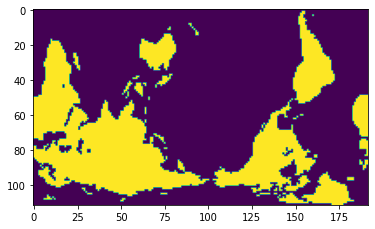

In [ ]:
plt.imshow(land_mask);

In [ ]:
for i in range(360) :
  area_burnt_p1[i][land_mask==-1] = -0.01
  area_burnt_p2[i][land_mask==-1] = -0.01
  area_burnt_p3[i][land_mask==-1] = -0.01

  T_data_p1[i][land_mask==-1] = -0.01
  T_data_p2[i][land_mask==-1] = -0.01
  T_data_p3[i][land_mask==-1] = -0.01

  veg_data_p1[i][land_mask==-1] = -0.01
  veg_data_p2[i][land_mask==-1] = -0.01
  veg_data_p3[i][land_mask==-1] = -0.01

  moist_data_p1[i][land_mask==-1] = -0.01
  moist_data_p2[i][land_mask==-1] = -0.01
  moist_data_p3[i][land_mask==-1] = -0.01

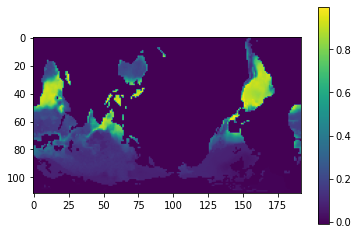

In [ ]:
im = plt.imshow(veg_data_p3[100]);
plt.colorbar(im);

### Split data - 300 first as training set - 60 last as testing set

In [ ]:
area_training_set_p1 = area_burnt_p1[0:360]
area_testing_set_p1 = area_burnt_p1[360:]
area_training_set_p2 = area_burnt_p2[0:360]
area_testing_set_p2 = area_burnt_p2[360:]
area_training_set_p3 = area_burnt_p3[0:360]
area_testing_set_p3 = area_burnt_p3[360:]

temp_training_set_p1 = T_data_p1[0:360]
temp_testing_set_p1 = T_data_p1[360:]
temp_training_set_p2 = T_data_p2[0:360]
temp_testing_set_p2 = T_data_p2[360:]
temp_training_set_p3 = T_data_p3[0:360]
temp_testing_set_p3 = T_data_p3[360:]

moist_training_set_p1 = moist_data_p1[0:360]
moist_testing_set_p1 = moist_data_p1[360:]
moist_training_set_p2 = moist_data_p2[0:360]
moist_testing_set_p2 = moist_data_p2[360:]
moist_training_set_p3 = moist_data_p3[0:360]
moist_testing_set_p3 = moist_data_p3[360:]

veg_training_set_p1 = veg_data_p1[0:360]
veg_testing_set_p1 = veg_data_p1[360:]
veg_training_set_p2 = veg_data_p2[0:360]
veg_testing_set_p2 = veg_data_p2[360:]
veg_training_set_p3 = veg_data_p3[0:360]
veg_testing_set_p3 = veg_data_p3[360:]

### CNN_LSTM 12 to 1

#### Process the training set for training model as multiple to one

##### Which means we process the training set so that it will be of the form :
```
xarray = [[month1, month2], [month2, month3], [month3, month4], ...]
yarray = [month3, month4, month5, ...]
```

for example if the number of pvious month taken into consideration is 2, and the number of futur forecast predicted is 1.

In [ ]:
#reorganise the data - here number of previous months =12 an number of futur months to predict =1
X_train12to1_p1, Y_train12to1_p1 = Select_previous_future_months(d_previous_months=12, n_futur_months=1, data=area_training_set_p1)
X_train12to1_p2, Y_train12to1_p2 = Select_previous_future_months(d_previous_months=12, n_futur_months=1, data=area_training_set_p2)
X_train12to1_p3, Y_train12to1_p3 = Select_previous_future_months(d_previous_months=12, n_futur_months=1, data=area_training_set_p3)

X_train12to1 = np.concatenate([X_train12to1_p1, X_train12to1_p2, X_train12to1_p3], axis=0)
Y_train12to1 = np.concatenate([Y_train12to1_p1, Y_train12to1_p2, Y_train12to1_p3], axis=0)

In [ ]:
print("Shape of training set for 3 previous month : ", X_train12to1.shape, " and the one of its response : ", Y_train12to1.shape)

Shape of training set for 3 previous month :  (1044, 12, 112, 192)  and the one of its response :  (1044, 1, 112, 192)


#### ConvLSTM basic architecture 12 months

In [ ]:
X_train12to1 = np.reshape(X_train12to1, newshape=(X_train12to1.shape[0], X_train12to1.shape[1], X_train12to1.shape[2], X_train12to1.shape[3], 1))
Y_train12to1 = np.reshape(Y_train12to1, newshape=(Y_train12to1.shape[0], Y_train12to1.shape[1], Y_train12to1.shape[2], Y_train12to1.shape[3], 1))

In [ ]:
train, val, ytrain, yval = train_test_split(X_train12to1, Y_train12to1, test_size=0.25, random_state=123, shuffle = True)

In [ ]:
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data4/train_masked.npy', train)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data4/ytrain_masked.npy', ytrain)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data4/val_masked.npy', val)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data4/yval_masked.npy', yval)

In [ ]:
train = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data4/train.npy', mmap_mode='r')
ytrain = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data4/ytrain.npy', mmap_mode='r')
val = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data4/val.npy', mmap_mode='r')
yval = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data4/yval.npy', mmap_mode='r')

In [ ]:
print('_______ Training set _________ ')
print('Shape of X training : ', train.shape)
print('Shape of Y training : ', ytrain.shape)

print('\n_______ Validation set _________ ')
print('Shape of X validation : ', val.shape)
print('Shape of Y validation : ', yval.shape)

_______ Training set _________ 
Shape of X training :  (783, 12, 112, 192, 1)
Shape of Y training :  (783, 1, 112, 192, 1)

_______ Validation set _________ 
Shape of X validation :  (261, 12, 112, 192, 1)
Shape of Y validation :  (261, 1, 112, 192, 1)


In [ ]:
# This cell parallelize the training of the model. 
# The mirrored strategy means the model will be run on severals GPUs with subsamples of the training data and will in the end put what they learnt in common.
# This is use to limit RAM explosion, and decrease computational time for training which could last for multiple hours otherwise. 
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 112, 192,   0         
                             1)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 112, 192, 2  15200     
                             0)                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, 112, 192, 2  0         
                             0)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 112, 192, 1  18960     
                             5)                                  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, None, 112, 192, 1  0     

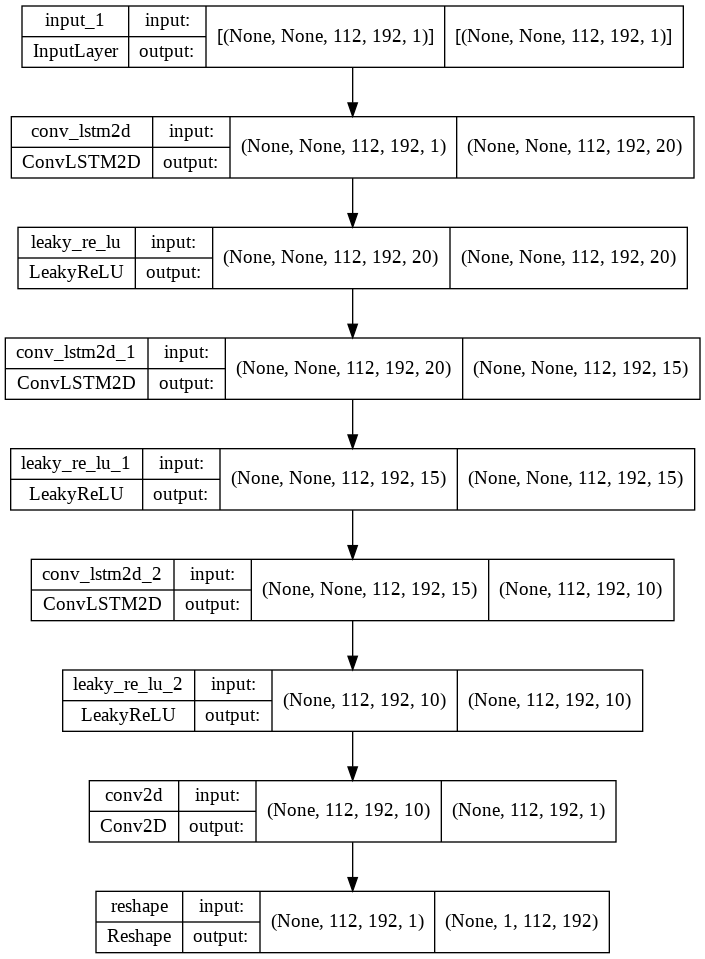

In [ ]:
# Above we can see we are working on 1 device, the GPU. But this cell tells us the mirrored strategy use all available CPU on this device 
#This tells to apply the model architecture as a mirrored strategy which will share and put in common training information. All CPU must work with the same model then.
with strategy.scope():
  inp = Input(shape=(None, *train.shape[2:]))

  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv2D` layer for the spatiotemporal outputs.
  x = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp)
  # x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  # x = MaxPooling3D((1,1,1))(x)

  x = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(x)
  # x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  # x = MaxPooling3D((1,1,1))(x)

  x = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(x)
  # x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  # x = MaxPooling3D((1,1,1))(x)

  #-------- This can be uncomment if you have better processor. It increases numebr of parameter but also model precision ----------
  # x = ConvLSTM2D(filters=64, kernel_size=(2, 2), padding="same", return_sequences=True, activation="relu", dropout=0.2)(x)
  # # x = BatchNormalization()(x)
  # x = LeakyReLU()(x)

  x = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(x)
  x = Reshape((1, 112, 192))(x)

  # Next, we will build the complete model and compile it.
  CNN12to1 = Model(inp, x)
  CNN12to1.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

CNN12to1.summary()

plot_model(CNN12to1, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=30,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=30)

In [ ]:
start = time.time()
history = CNN12to1.fit(
    train,
    ytrain,
    batch_size = 3,
    epochs=120,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/120
209/209 [==============================] - 81s 389ms/step - loss: 5.8979e-06 - val_loss: 5.5950e-06 - lr: 1.0000e-06
Epoch 2/120
209/209 [==============================] - 77s 367ms/step - loss: 5.8850e-06 - val_loss: 5.5943e-06 - lr: 1.0000e-06
Epoch 3/120
209/209 [==============================] - 76s 365ms/step - loss: 5.9065e-06 - val_loss: 5.5954e-06 - lr: 1.0000e-06
Epoch 4/120
209/209 [==============================] - 77s 367ms/step - loss: 5.8165e-06 - val_loss: 5.5958e-06 - lr: 1.0000e-06
Epoch 5/120
209/209 [==============================] - 76s 366ms/step - loss: 5.8452e-06 - val_loss: 5.5958e-06 - lr: 1.0000e-06
Epoch 6/120
209/209 [==============================] - 76s 366ms/step - loss: 5.9432e-06 - val_loss: 5.5971e-06 - lr: 1.0000e-06
Epoch 7/120
209/209 [==============================] - 77s 366ms/step - loss: 5.8336e-06 - val_loss: 5.5967e-06 - lr: 1.0000e-06
Epoch 8/120
209/209 [==============================] - 76s 363ms/step - loss: 5.9127e-06 - val_lo

______________ Loss plot of CAE + LSTM with 3 months as inputs__________________



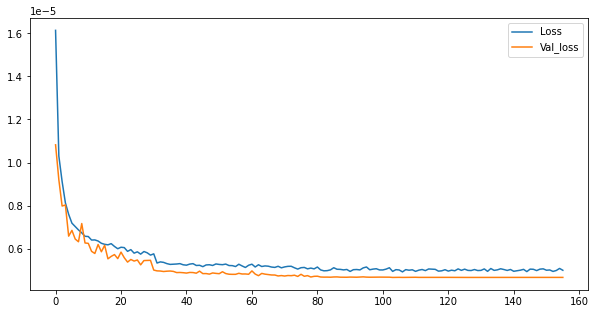

In [ ]:
print("______________ Loss plot of CAE + LSTM with 3 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(loss1)
plt.plot(valloss1)
plt.legend(['Loss', 'Val_loss']);

In [ ]:
loss1 = history.history['loss']
valloss1 = history.history['val_loss']

In [ ]:
# Saving the model
#CNN12to1.save('/content/drive/MyDrive/Wildfires_IRP/model/CNN_LSTM/CNN_LSTM_12to1_v2.h5')
CNN12to1 = load_model('/content/drive/MyDrive/Wildfires_IRP/model/CNN_LSTM/CNN_LSTM_12to1.h5')

In [ ]:
predictions = CNN12to1.predict(val)
print("Shape of the predictions : ", predictions.shape)

Shape of the predictions :  (261, 1, 112, 192)


In [ ]:
preds = np.squeeze(predictions)
yval = np.squeeze(yval)

____________ Real images ________________


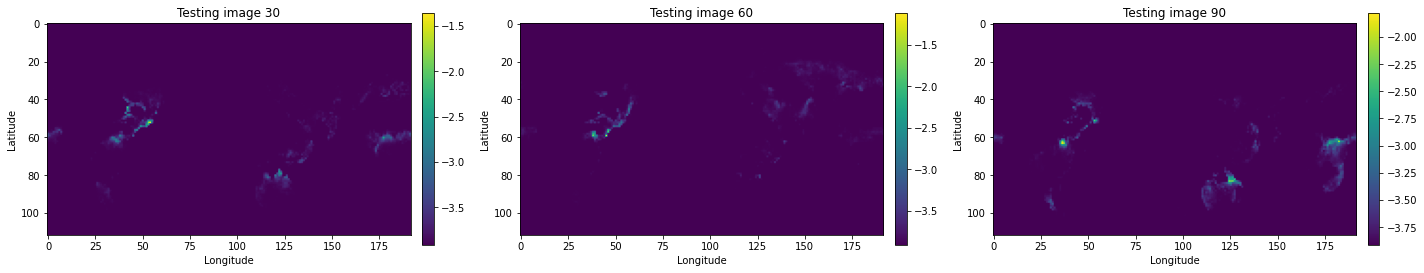

____________ Predictions CNN LSTM 12 to 12 _____________ 


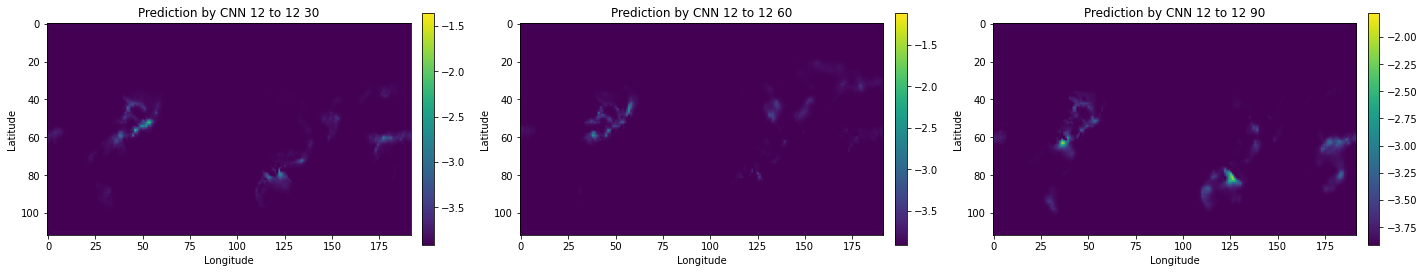

____________ Difference between both _____________ 


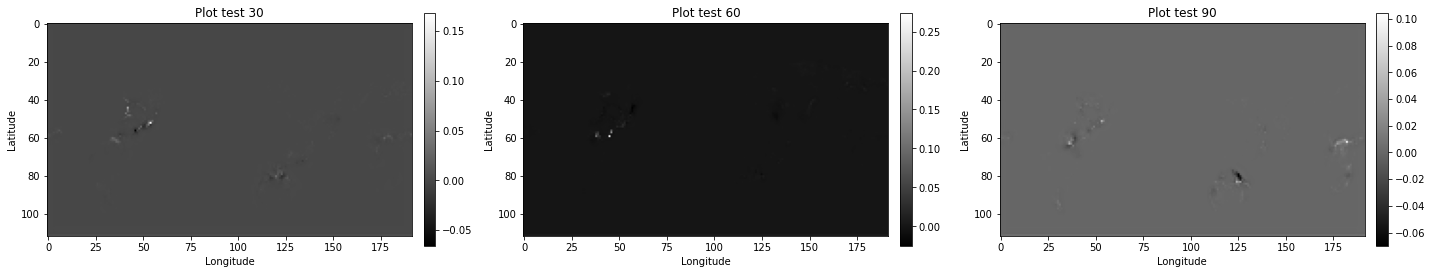

In [ ]:
#Plot 12 to 1 
print("____________ Real images ________________")
plot_data_img(1, 3, data = yval, true_data=yval, ts=[30, 60, 90], title='Testing image', threshold=0.02)

print("____________ Predictions CNN LSTM 12 to 12 _____________ ")
plot_data_img(1, 3, data = preds, true_data=yval, ts = [30, 60, 90], title='Prediction by CNN 12 to 12', threshold=0.02)

print("____________ Difference between both _____________ ")
plot_data_img_diff(1, 3, data1 = preds, data2 = yval, ts = [30, 60, 90])

____________ Real images ________________


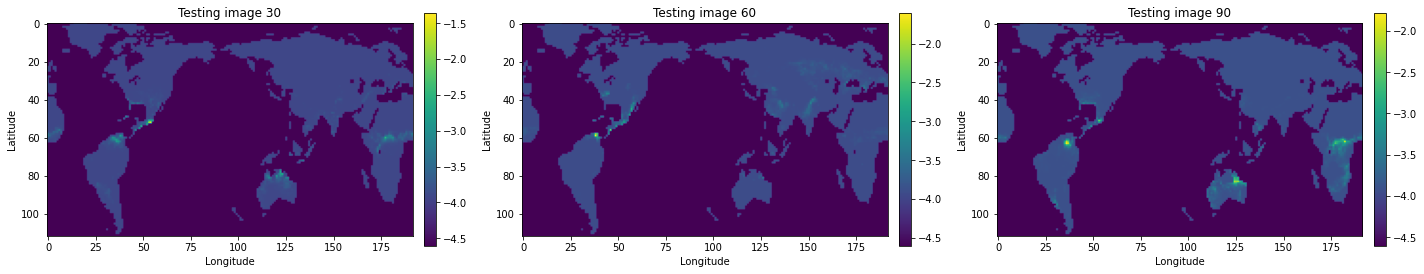

____________ Predictions CNN LSTM 12 to 12 _____________ 


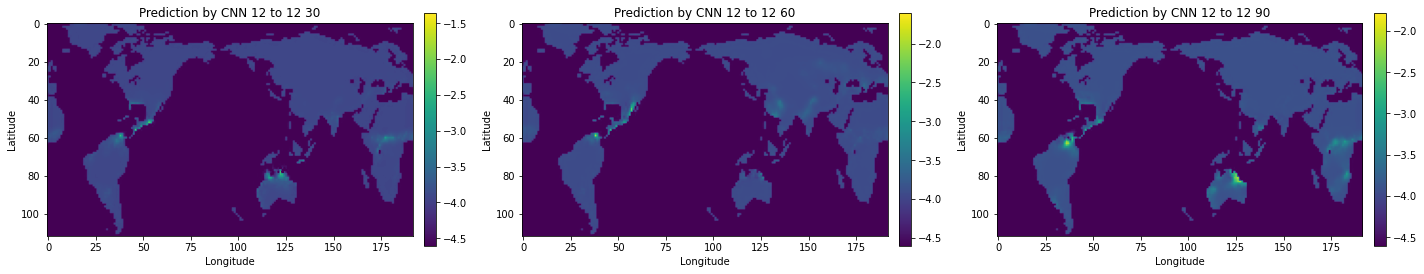

____________ Difference between both _____________ 


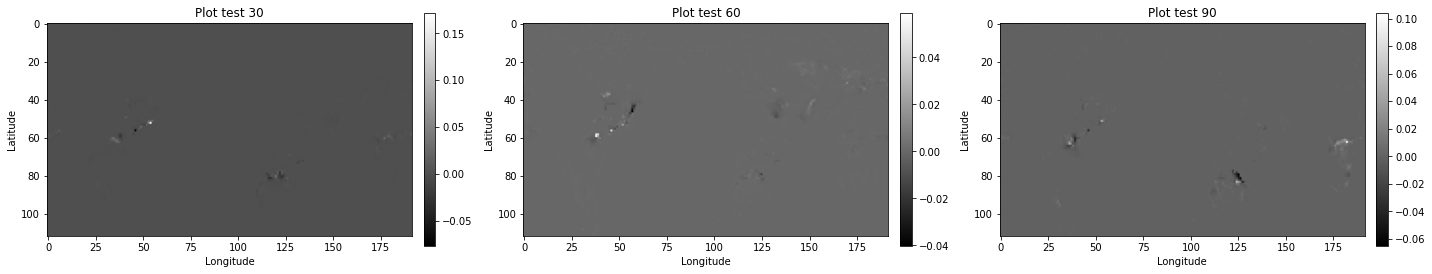

In [ ]:
#Plot 12 to 1 
print("____________ Real images ________________")
plot_data_img(1, 3, data = yval, true_data=yval, ts=[30, 60, 90], title='Testing image', threshold=0.02)

print("____________ Predictions CNN LSTM 12 to 12 _____________ ")
plot_data_img(1, 3, data = preds, true_data=yval, ts = [30, 60, 90], title='Prediction by CNN 12 to 12', threshold=0.02)

print("____________ Difference between both _____________ ")
plot_data_img_diff(1, 3, data1 = preds, data2 = yval, ts = [30, 60, 90])

In [ ]:
#Display the performances of the model (MSE) on training and testing set.
pred_train = CNN12to1.predict(train[:])
relative_mse_train = np.linalg.norm(pred_train - np.squeeze(ytrain[:])) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain[:].ravel())
print("____________ Training _____________")
print("Mse of prediction on training set : ", relative_mse_train)
print("Time for training : ", round(13294.545, 3), "s")

relative_mse_test = np.linalg.norm(predictions - np.squeeze(yval)) / (112*192)
mse_test = mean_squared_error(predictions.ravel(), yval.ravel())
print("\n____________ Validation ___________")
print("Mse of prediction on validation set : ", relative_mse_test)

### CNN_LSTM 12 to 12

#### ConvLSTM basic architecture 12 months

In [ ]:
train = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/train.npy', mmap_mode='r')
ytrain = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/ytrain.npy', mmap_mode='r')
val = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/val.npy', mmap_mode='r')
yval = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/yval.npy', mmap_mode='r')

In [ ]:
train = train[:, :, :, :, :1]
ytrain = ytrain[:, :, :, :, :1]
val = val[:, :, :, :, :1]
yval = yval[:, :, :, :, :1]

In [ ]:
print('_______ Training set _________ ')
print('Shape of X training : ', train.shape)
print('Shape of Y training : ', ytrain.shape)

print('\n_______ Validation set _________ ')
print('Shape of X validation : ', val.shape)
print('Shape of Y validation : ', yval.shape)

_______ Training set _________ 
Shape of X training :  (505, 12, 112, 192, 1)
Shape of Y training :  (505, 12, 112, 192, 1)

_______ Validation set _________ 
Shape of X validation :  (169, 12, 112, 192, 1)
Shape of Y validation :  (169, 12, 112, 192, 1)


In [ ]:
#Explained in CNN LSTM 12 to 1 part
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 112, 192,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 112, 192, 2  15200     
                           

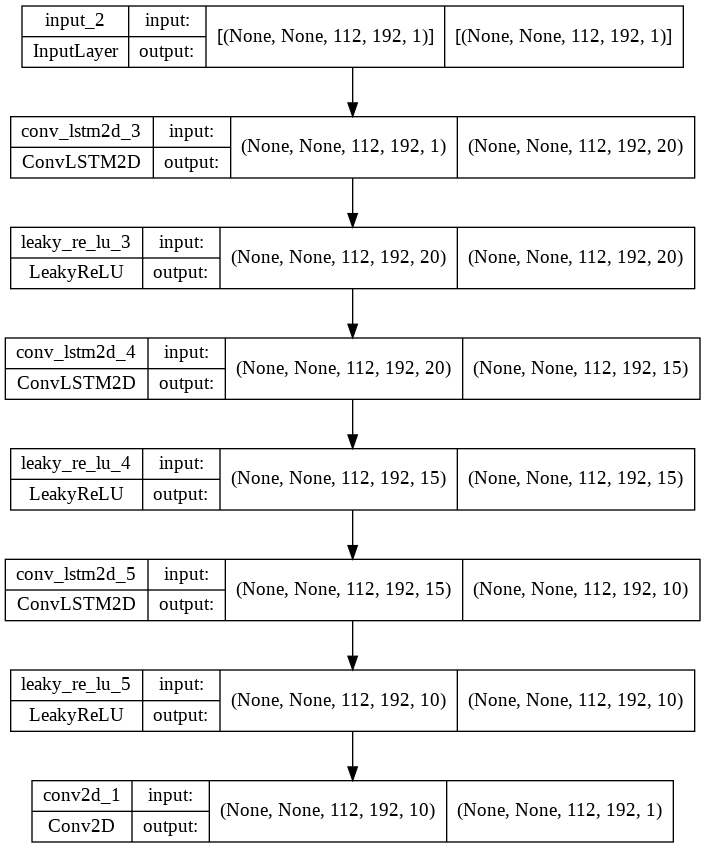

In [ ]:
#Explained in CNN LSTM 12 to 1 part
with strategy.scope():
  inp = Input(shape=(None, *train.shape[2:]))

  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv2D` layer for the spatiotemporal outputs.
  x = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp)
  # x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  # x = MaxPooling3D((1,1,1))(x)

  x = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(x)
  # x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  # x = MaxPooling3D((1,1,1))(x)

  x = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(x)
  # x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  # x = MaxPooling3D((1,1,1))(x)

  # ---- To uncomment in case of better processors ---- Increase number of parameter but also model precision ----- 
  # x = ConvLSTM2D(filters=64, kernel_size=(2, 2), padding="same", return_sequences=True, activation="relu", dropout=0.2)(x)
  # # x = BatchNormalization()(x)
  # x = LeakyReLU()(x)

  x = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(x)

  # Next, we will build the complete model and compile it.
  CNN12to12 = Model(inp, x)
  CNN12to12.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

CNN12to12.summary()

plot_model(CNN12to12, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=30,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=30)

In [ ]:
start = time.time()
history = CNN12to1.fit(
    train,
    ytrain,
    batch_size = 3,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/100
135/135 [==============================] - 60s 444ms/step - loss: 6.9908e-06 - val_loss: 6.1618e-06 - lr: 1.0000e-04
Epoch 2/100
135/135 [==============================] - 52s 384ms/step - loss: 7.0248e-06 - val_loss: 6.1545e-06 - lr: 1.0000e-04
Epoch 3/100
135/135 [==============================] - 51s 380ms/step - loss: 7.0030e-06 - val_loss: 6.1567e-06 - lr: 1.0000e-04
Epoch 4/100
135/135 [==============================] - 52s 384ms/step - loss: 7.0180e-06 - val_loss: 6.1484e-06 - lr: 1.0000e-04
Epoch 5/100
135/135 [==============================] - 51s 380ms/step - loss: 7.0353e-06 - val_loss: 6.1512e-06 - lr: 1.0000e-04
Epoch 6/100
135/135 [==============================] - 52s 384ms/step - loss: 7.0194e-06 - val_loss: 6.1481e-06 - lr: 1.0000e-04
Epoch 7/100
135/135 [==============================] - 51s 380ms/step - loss: 7.0092e-06 - val_loss: 6.1487e-06 - lr: 1.0000e-04
Epoch 8/100
135/135 [==============================] - 52s 382ms/step - loss: 6.9871e-06 - val_lo

In [ ]:
loss2 = history.history['loss']
valloss2 = history.history['val_loss']

______________ Loss plot of CAE + LSTM with 3 months as inputs__________________



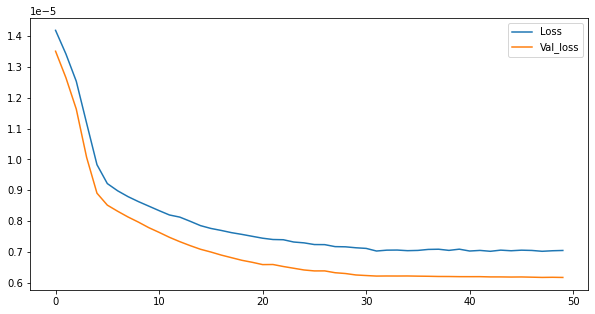

In [ ]:
print("______________ Loss plot of CAE + LSTM with 3 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(loss1)
plt.plot(valloss1)
plt.legend(['Loss', 'Val_loss']);

In [ ]:
# Saving the model
CNN12to1.save('/content/drive/MyDrive/Wildfires_IRP/model/CNN_LSTM/CNN_LSTM_12to12.h5')
#CNN12to12 = load_model('/content/drive/MyDrive/Wildfires_IRP/model/CNN_LSTM/CNN_LSTM_12to12.h5')

In [ ]:
predictions = CNN12to1.predict(val)
print("Shape of the predictions : ", predictions.shape)

Shape of the predictions :  (169, 12, 112, 192, 1)


In [ ]:
preds = np.squeeze(predictions)
yval = np.squeeze(yval)

____________ Real images ________________


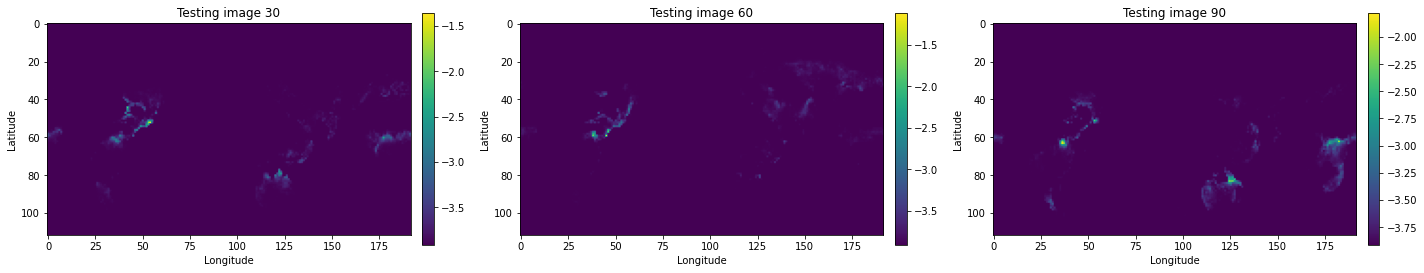

____________ Predictions CNN LSTM 12 to 12 _____________ 


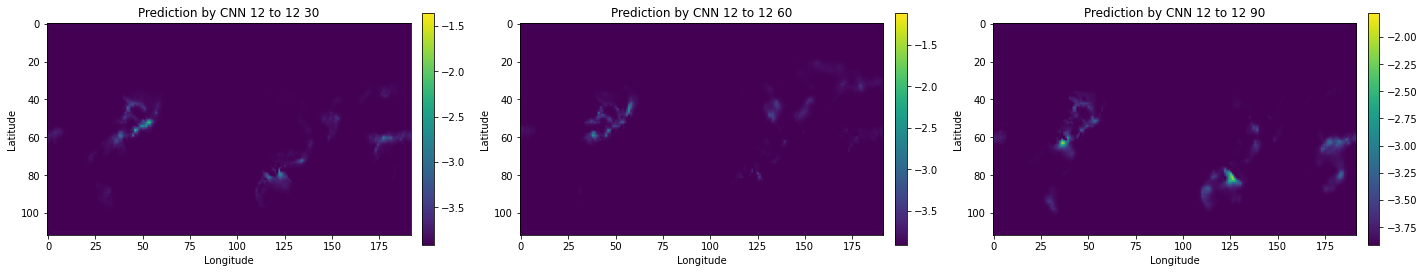

____________ Difference between both _____________ 


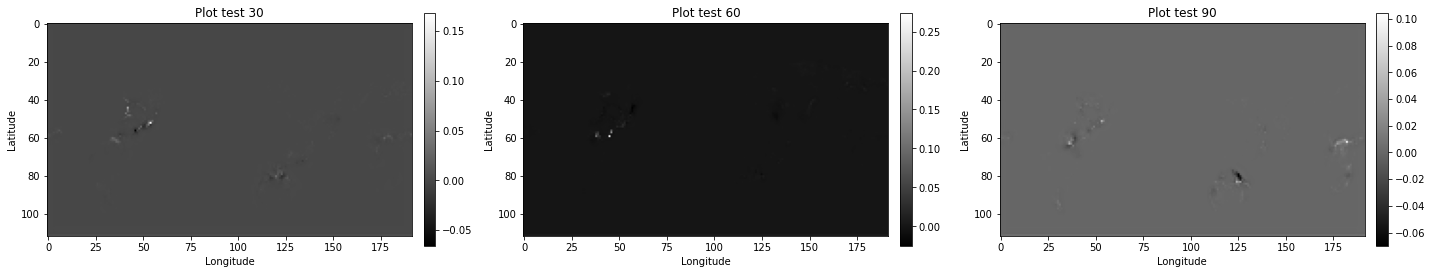

In [ ]:
#Plot 12 to 1 
print("____________ Real images ________________")
plot_data_img(1, 3, data = yval, true_data=yval, ts=[30, 60, 90], title='Testing image', threshold=0.02)

print("____________ Predictions CNN LSTM 12 to 12 _____________ ")
plot_data_img(1, 3, data = preds, true_data=yval, ts = [30, 60, 90], title='Prediction by CNN 12 to 12', threshold=0.02)

print("____________ Difference between both _____________ ")
plot_data_img_diff(1, 3, data1 = preds, data2 = yval, ts = [30, 60, 90])

____________ Real images ________________


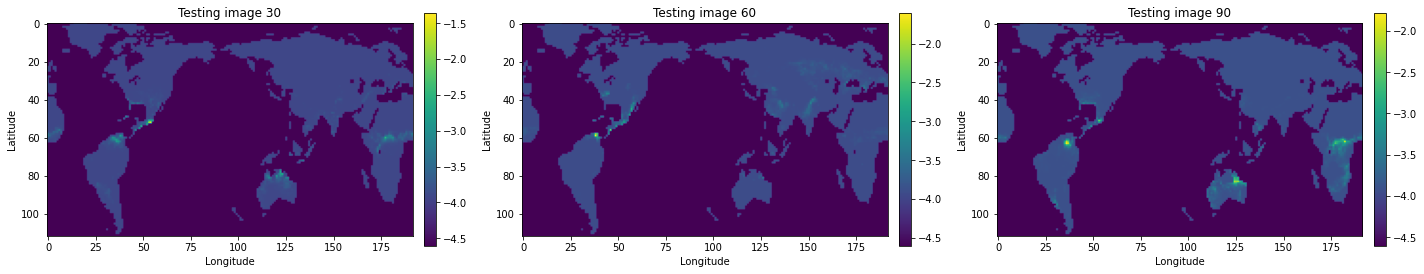

____________ Predictions CNN LSTM 12 to 12 _____________ 


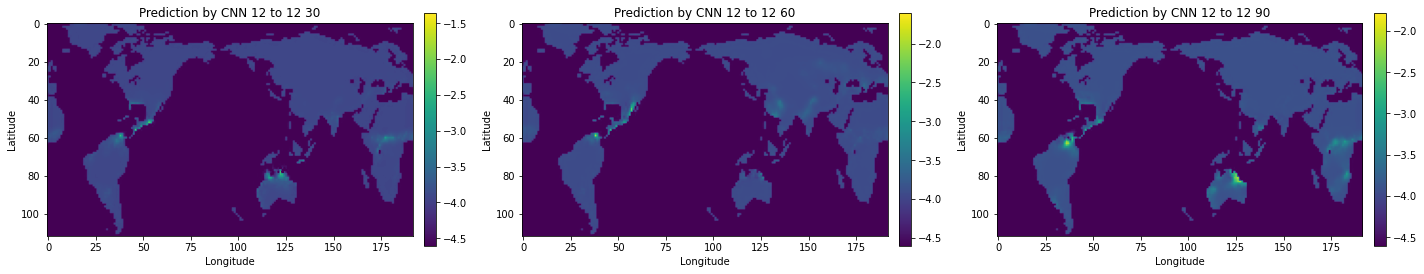

____________ Difference between both _____________ 


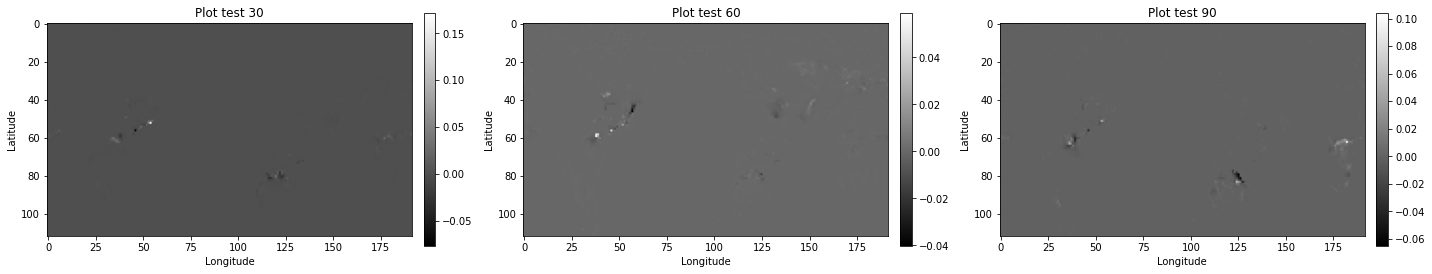

In [ ]:
#Plot 12 to 1 
print("____________ Real images ________________")
plot_data_img(1, 3, data = yval, true_data=yval, ts=[30, 60, 90], title='Testing image', threshold=0.02)

print("____________ Predictions CNN LSTM 12 to 12 _____________ ")
plot_data_img(1, 3, data = preds, true_data=yval, ts = [30, 60, 90], title='Prediction by CNN 12 to 12', threshold=0.02)

print("____________ Difference between both _____________ ")
plot_data_img_diff(1, 3, data1 = preds, data2 = yval, ts = [30, 60, 90])

In [ ]:
#Display the performances of the model on training and testing set.
pred_train = CNN12to1.predict(train[:])
relative_mse_train = np.linalg.norm(pred_train - np.squeeze(ytrain[:])) / (112*192)
mse_train = mean_squared_error(pred_train.ravel(), ytrain[:].ravel())
print("____________ Training _____________")
print("Mse of prediction on training set : ", relative_mse_train)
print("Time for training : ", round(13294.545, 3), "s")

relative_mse_test = np.linalg.norm(predictions - np.squeeze(yval)) / (112*192)
mse_test = mean_squared_error(predictions.ravel(), yval.ravel())
print("\n____________ Validation ___________")
print("Mse of prediction on validation set : ", relative_mse_test)

## CNN LSTM multi var

**All multi-var CNN have been built in a similar way. Model takes each of the four environmental variables and processes it separately in a specific channel. Then th epredictions are put in common in a final layer.**

**However, this architecture doesn't seem to share any informations between the seprate channels which means the first channel predicting the total area burnt doesn't use vegetation, temperature and soil mositure to predict the next area burnt.**


**Some architectures trying to share informations during training have been tried and are displayed in Appendix section.**

### Import the scaled data

In [ ]:
#saving the reshaped scaled images
area_burnt_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_dta_p1_scaled.npy")
area_burnt_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_dta_p2_scaled.npy")
area_burnt_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_dta_p3_scaled.npy")

T_data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_T_p1_scaled.npy")
T_data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_T_p2_scaled.npy")
T_data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_T_p3_scaled.npy")

veg_data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_veg_p1_scaled.npy")
veg_data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_veg_p2_scaled.npy")
veg_data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_veg_p3_scaled.npy")

moist_data_p1 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p1/monthly_moisture_p1_scaled.npy")
moist_data_p2 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p2/monthly_moisture_p2_scaled.npy")
moist_data_p3 = np.load("/content/drive/MyDrive/Wildfires_IRP/data/p3/monthly_moisture_p3_scaled.npy")

In [ ]:
area_training_set_p1 = area_burnt_p1[0:360]
area_testing_set_p1 = area_burnt_p1[360:]
area_training_set_p2 = area_burnt_p2[0:360]
area_testing_set_p2 = area_burnt_p2[360:]
area_training_set_p3 = area_burnt_p3[0:360]
area_testing_set_p3 = area_burnt_p3[360:]

temp_training_set_p1 = T_data_p1[0:360]
temp_testing_set_p1 = T_data_p1[360:]
temp_training_set_p2 = T_data_p2[0:360]
temp_testing_set_p2 = T_data_p2[360:]
temp_training_set_p3 = T_data_p3[0:360]
temp_testing_set_p3 = T_data_p3[360:]

moist_training_set_p1 = moist_data_p1[0:360]
moist_testing_set_p1 = moist_data_p1[360:]
moist_training_set_p2 = moist_data_p2[0:360]
moist_testing_set_p2 = moist_data_p2[360:]
moist_training_set_p3 = moist_data_p3[0:360]
moist_testing_set_p3 = moist_data_p3[360:]

veg_training_set_p1 = veg_data_p1[0:360]
veg_testing_set_p1 = veg_data_p1[360:]
veg_training_set_p2 = veg_data_p2[0:360]
veg_testing_set_p2 = veg_data_p2[360:]
veg_training_set_p3 = veg_data_p3[0:360]
veg_testing_set_p3 = veg_data_p3[360:]

In [ ]:
multivar_data_p1 = np.asarray([area_training_set_p1, moist_training_set_p1, temp_training_set_p1, veg_training_set_p1])
multivar_data_p2 = np.asarray([area_training_set_p2, moist_training_set_p2, temp_training_set_p2, veg_training_set_p2])
multivar_data_p3 = np.asarray([area_training_set_p3, moist_training_set_p3, temp_training_set_p3, veg_training_set_p3])

In [ ]:
multivar_data_p1 = np.swapaxes(multivar_data_p1, axis1=0, axis2=1)
multivar_data_p2 = np.swapaxes(multivar_data_p2, axis1=0, axis2=1)
multivar_data_p3 = np.swapaxes(multivar_data_p3, axis1=0, axis2=1)

In [ ]:
multivar_data_p1 = np.expand_dims(multivar_data_p1, axis=-1)
multivar_data_p2 = np.expand_dims(multivar_data_p2, axis=-1)
multivar_data_p3 = np.expand_dims(multivar_data_p3, axis=-1)

### Multi var CNN LSTM 12 to 1

In [ ]:
#Reorganising the data in sequence of 12 previous months to next months
X_train12to1_p1, Y_train12to1_p1 = Select_previous_future_months(d_previous_months=12, n_futur_months=1, data=multivar_data_p1)
X_train12to1_p2, Y_train12to1_p2 = Select_previous_future_months(d_previous_months=12, n_futur_months=1, data=multivar_data_p2)
X_train12to1_p3, Y_train12to1_p3 = Select_previous_future_months(d_previous_months=12, n_futur_months=1, data=multivar_data_p3)

X_train12to1 = np.swapaxes(np.concatenate([X_train12to1_p1, X_train12to1_p2, X_train12to1_p3], axis=0), axis1=2, axis2=5)
Y_train12to1 = np.swapaxes(np.concatenate([Y_train12to1_p1, Y_train12to1_p2, Y_train12to1_p3], axis=0), axis1=2, axis2=5)

X_train12to1 = np.reshape(X_train12to1, newshape=(X_train12to1.shape[0], 12, 112, 192, 4))
Y_train12to1 = np.reshape(Y_train12to1, newshape=(Y_train12to1.shape[0], 1, 112, 192, 4))

In [ ]:
print("Shape of training set for 3 previous month : ", X_train12to1.shape, " and the one of its response : ", Y_train12to1.shape)

Shape of training set for 3 previous month :  (1044, 12, 112, 192, 4)  and the one of its response :  (1044, 1, 112, 192, 4)


In [ ]:
train, val, ytrain, yval = train_test_split(X_train12to1, Y_train12to1, test_size=0.25, random_state=123, shuffle=True)

In [ ]:
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data5/train_masked.npy', train)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data5/ytrain_masked.npy', ytrain)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data5/val_masked.npy', val)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data5/yval_masked.npy', yval)

In [ ]:
train = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data5/train.npy', mmap_mode='r')
ytrain = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data5/ytrain.npy', mmap_mode='r')
val = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data5/val.npy', mmap_mode='r')
yval = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data5/yval.npy', mmap_mode='r')

In [ ]:
print('_______ Training set _________ ')
print('Shape of X training : ', train.shape)
print('Shape of Y training : ', ytrain.shape)

print('\n_______ Validation set _________ ')
print('Shape of X validation : ', val.shape)
print('Shape of Y validation : ', yval.shape)

_______ Training set _________ 
Shape of X training :  (783, 12, 112, 192, 4)
Shape of Y training :  (783, 1, 112, 192, 4)

_______ Validation set _________ 
Shape of X validation :  (261, 12, 112, 192, 4)
Shape of Y validation :  (261, 1, 112, 192, 4)


In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

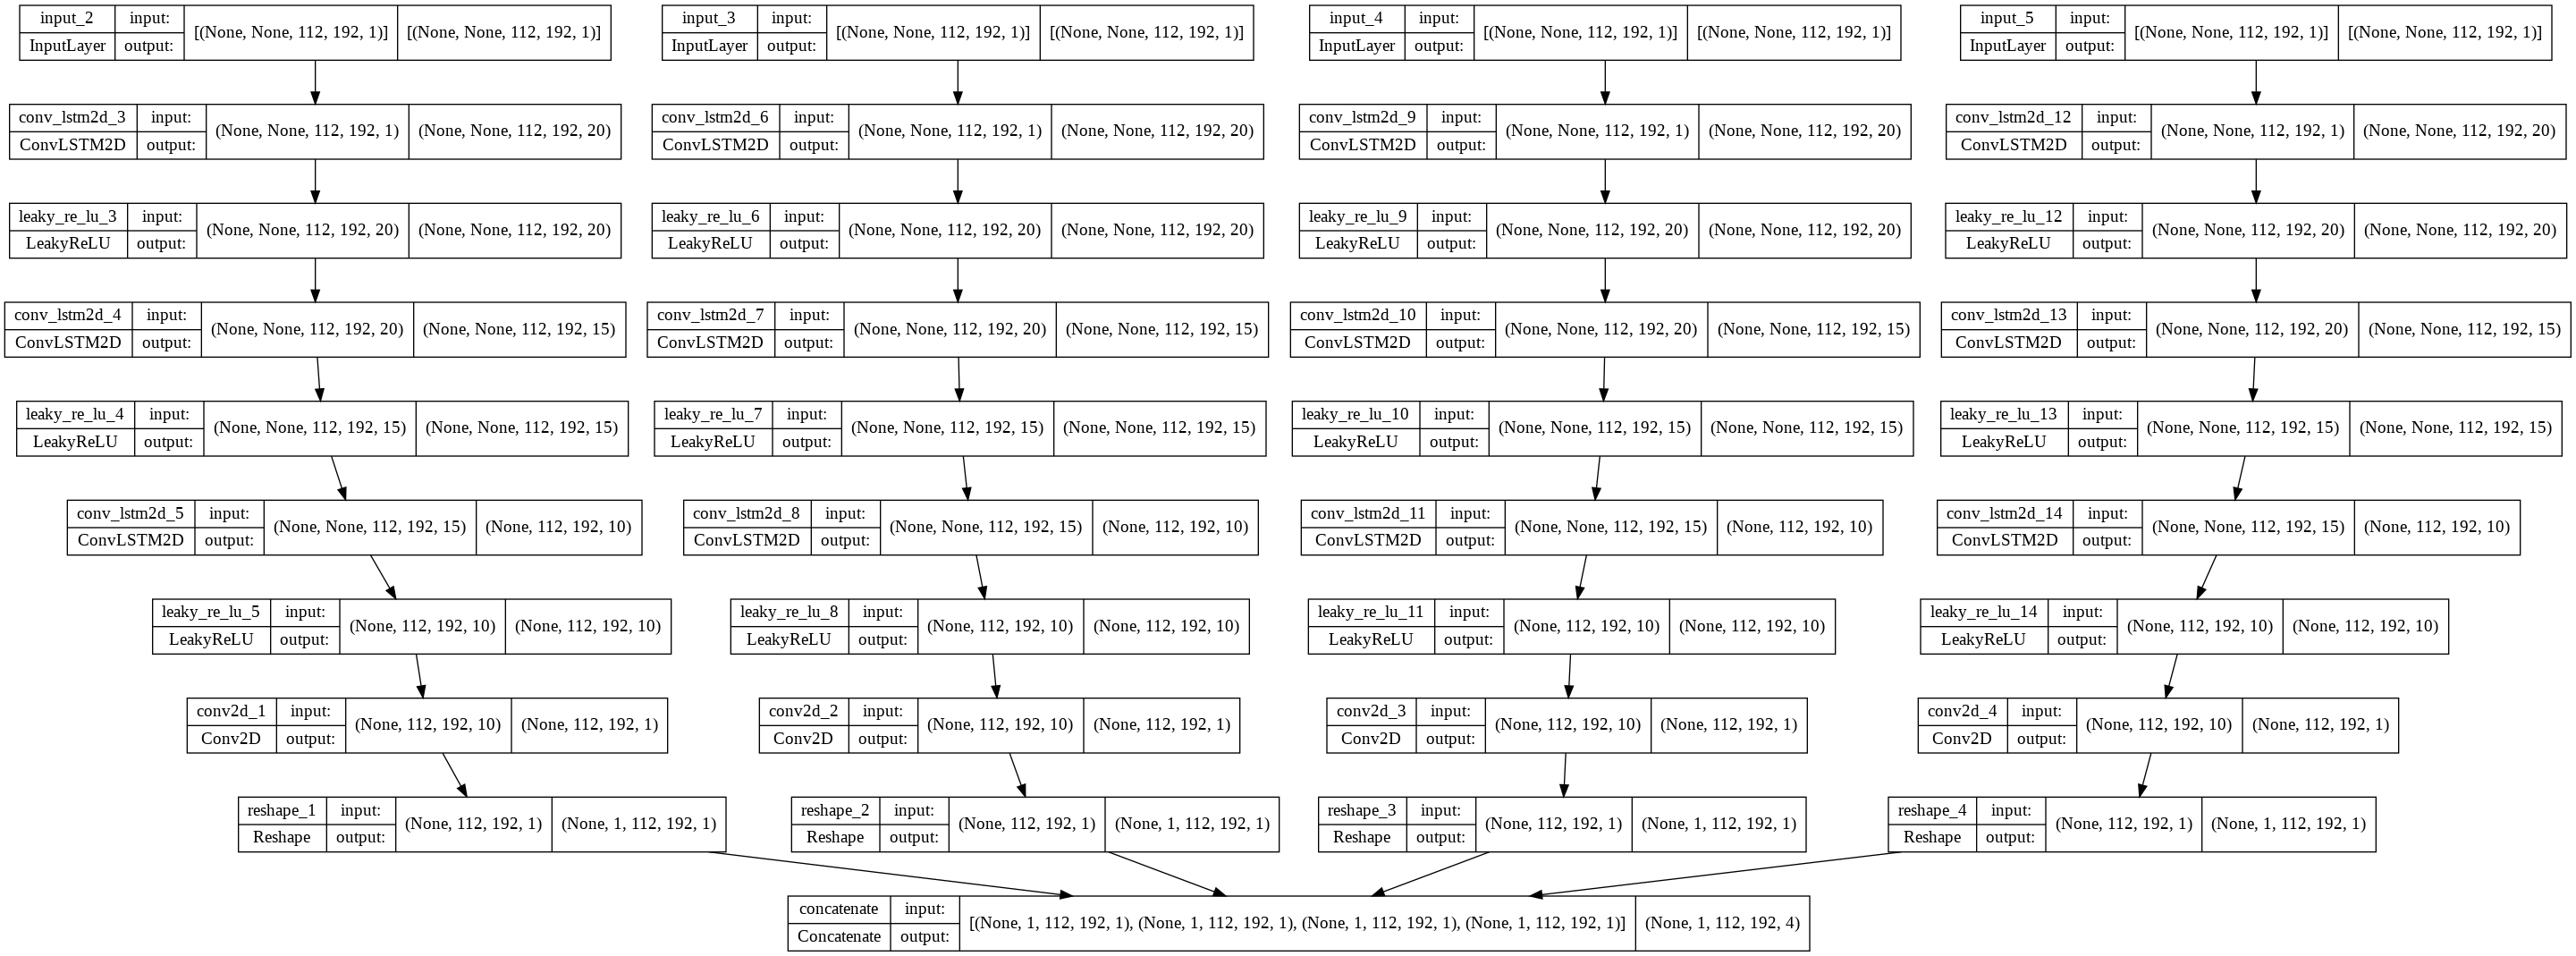

In [ ]:
with strategy.scope():
  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv3D` layer for the spatiotemporal outputs.
  inp1 = Input(shape=(None, 112, 192, 1))
  banch1 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU()(banch1)
  banch1 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch1)
  output1 = Reshape((1, 112, 192, 1))(banch1)

  inp2 = Input(shape=(None, 112, 192, 1))
  banch2 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU()(banch2)
  banch2 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch2)
  output2 = Reshape((1, 112, 192, 1))(banch2)

  inp3 = Input(shape=(None, 112, 192, 1))
  banch3 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU()(banch3)
  banch3 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch3)
  output3 = Reshape((1, 112, 192, 1))(banch3)

  inp4 = Input(shape=(None, 112, 192, 1))
  banch4 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU()(banch4)
  banch4 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch4)
  output4 = Reshape((1, 112, 192, 1))(banch4)

  #concatenate the four branch
  merging = Concatenate(axis=4)([output1, output2, output3, output4])

  # # Final layer to combine the features
  # FL = Conv2D(filters=10, kernel_size=(5, 5), activation="elu", padding="same")(merging)
  # final_output = Conv2D(filters=4, kernel_size=(5, 5), activation="elu", padding="same")(FL)

  Next, we will build the complete model and compile it.
  multi_CNN12to1 = Model([inp1, inp2, inp3, inp4], merging)
  # multi_CNN12to1 = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_12to1_v2.h5')
  multi_CNN12to1.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

multi_CNN12to1.summary()

plot_model(multi_CNN12to1, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=30,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=30)

In [ ]:
start = time.time()
history = multi_CNN12to1.fit(
    [train[:, :, :, :, :1], train[:, :, :, :, 1:2], train[:, :, :, :, 2:3], train[:, :, :, :, 3:]],
    ytrain[:],
    batch_size = 3,
    epochs=100,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
209/209 [==============================] - 360s 2s/step - loss: 5.2875e-04 - val_loss: 9.2913e-04 - lr: 0.0010
Epoch 2/100
209/209 [==============================] - 303s 1s/step - loss: 3.9620e-04 - val_loss: 8.0767e-04 - lr: 0.0010
Epoch 3/100
209/209 [==============================] - 303s 1s/step - loss: 3.8348e-04 - val_loss: 5.1857e-04 - lr: 0.0010
Epoch 4/100
209/209 [==============================] - 304s 1s/step - loss: 3.6201e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 5/100
209/209 [==============================] - 303s 1s/step - loss: 3.4329e-04 - val_loss: 6.1914e-04 - lr: 0.0010
Epoch 6/100
209/209 [==============================] - 303s 1s/step - loss: 3.3059e-04 - val_loss: 0.0014 - l

In [ ]:
#multi_CNN12to1.save('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_12to1_v2.h5')
multi_CNN12to1 = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_12to1_v2.h5')

______________ Loss plot of CAE + LSTM with 3 months as inputs__________________



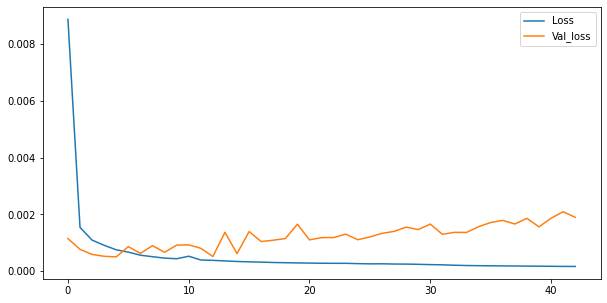

In [ ]:
print("______________ Loss plot of CAE + LSTM with 3 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(loss1)
plt.plot(valloss1)
plt.legend(['Loss', 'Val_loss']);

In [ ]:
predictions = multi_CNN12to1.predict([val[:, :, :, :, :1], val[:, :, :, :, 1:2], val[:, :, :, :, 2:3], val[:, :, :, :, 3:]])
# print("Shape of the predictions : ", predictions.shape)
preds= np.asarray(predictions)

In [ ]:
pred_train = np.asarray(multi_CNN12to1.predict([train[:, :, :, :, :1], train[:, :, :, :, 1:2], train[:, :, :, :, 2:3], train[:, :, :, :, 3:]]))
relative_mse_train = np.linalg.norm(pred_train - ytrain[:]) / (112*192)
print("____________ Training _____________")
print("Mse of prediction on training set : ", relative_mse_train)
print("Time for training : ", round(1256789, 3), "s")

relative_mse_test = np.linalg.norm(preds - yval)/ (112*192)
print("\n____________ Validation ___________")
print("Mse of prediction on validation set : ", relative_mse_test)

____________ Training _____________
Mse of prediction on training set :  0.018029301417905198
Time for training :  1256789 s

____________ Validation ___________
Mse of prediction on validation set :  0.010512835599900636


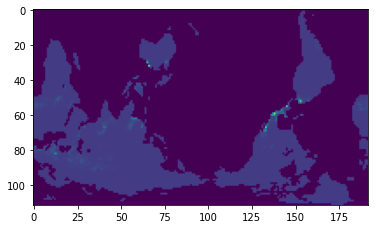

In [ ]:
plt.show(plt.imshow(yval[23,0,:,:, 0]))

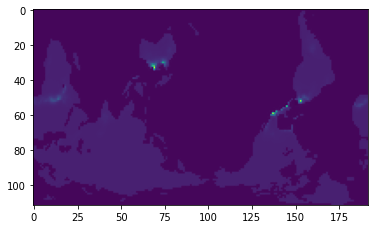

In [ ]:
plt.show(plt.imshow(preds[25,0,:,:, 0]))

In [ ]:
pred_train = np.asarray(multi_CNN12to1.predict([train[:, :, :, :, :1], train[:, :, :, :, 1:2], train[:, :, :, :, 2:3], train[:, :, :, :, 3:]]))
relative_mse_train = np.linalg.norm(pred_train - ytrain[:]) / (112*192)
print("____________ Training _____________")
print("Mse of prediction on training set : ", relative_mse_train)
print("Time for training : ", round(1256789, 3), "s")

relative_mse_test = np.linalg.norm(preds - yval)/ (112*192)
print("\n____________ Validation ___________")
print("Mse of prediction on validation set : ", relative_mse_test)

____________ Training _____________
Mse of prediction on training set :  0.0086566465465697
Time for training :  1256789 s

____________ Validation ___________
Mse of prediction on validation set :  0.005038668839057207


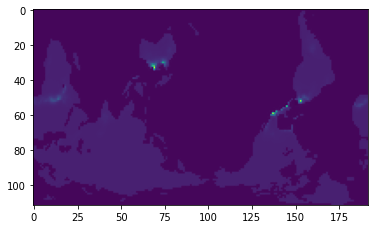

In [ ]:
plt.show(plt.imshow(preds[25,0,:,:, 0]))

### Multi var CNN LSTM 12 to 12

In [ ]:
#try for 3 months
X_train12to12_p1, Y_train12to12_p1 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=multivar_data_p1)
X_train12to12_p2, Y_train12to12_p2 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=multivar_data_p2)
X_train12to12_p3, Y_train12to12_p3 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=multivar_data_p3)

X_train12to12 = np.swapaxes(np.concatenate([X_train12to12_p1, X_train12to12_p3], axis=0), axis1=2, axis2=5)
Y_train12to12 = np.swapaxes(np.concatenate([Y_train12to12_p1, Y_train12to12_p3], axis=0), axis1=2, axis2=5)

X_train12to12 = np.reshape(X_train12to12, newshape=(X_train12to12.shape[0], 12, 112, 192, 4))
Y_train12to12 = np.reshape(Y_train12to12, newshape=(Y_train12to12.shape[0], 12, 112, 192, 4))

In [ ]:
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/train.npy', X_train12to12)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/ytrain.npy', Y_train12to12)

In [ ]:
X_train12to12 = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/train.npy', mmap_mode='r')
Y_train12to12 = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/ytrain.npy', mmap_mode='r')

In [ ]:
print("Shape of training set for 3 previous month : ", X_train12to12.shape, " and the one of its response : ", Y_train12to12.shape)

Shape of training set for 3 previous month :  (324, 12, 112, 192, 4)  and the one of its response :  (324, 12, 112, 192, 4)


In [ ]:
train, val, ytrain, yval = train_test_split(X_train12to12, Y_train12to12, test_size=0.25, random_state=123, shuffle=True)

In [ ]:
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/train.npy', train)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/ytrain.npy', ytrain)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/val.npy', val)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/yval.npy', yval)

In [ ]:
train = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/train.npy', mmap_mode='r')
ytrain = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/ytrain.npy', mmap_mode='r')
val = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/val.npy', mmap_mode='r')
yval = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data2/yval.npy', mmap_mode='r')

In [ ]:
print('_______ Training set _________ ')
print('Shape of X training : ', train.shape)
print('Shape of Y training : ', ytrain.shape)

print('\n_______ Validation set _________ ')
print('Shape of X validation : ', val.shape)
print('Shape of Y validation : ', yval.shape)

_______ Training set _________ 
Shape of X training :  (505, 12, 112, 192, 4)
Shape of Y training :  (505, 12, 112, 192, 4)

_______ Validation set _________ 
Shape of X validation :  (169, 12, 112, 192, 4)
Shape of Y validation :  (169, 12, 112, 192, 4)


In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                          
                             

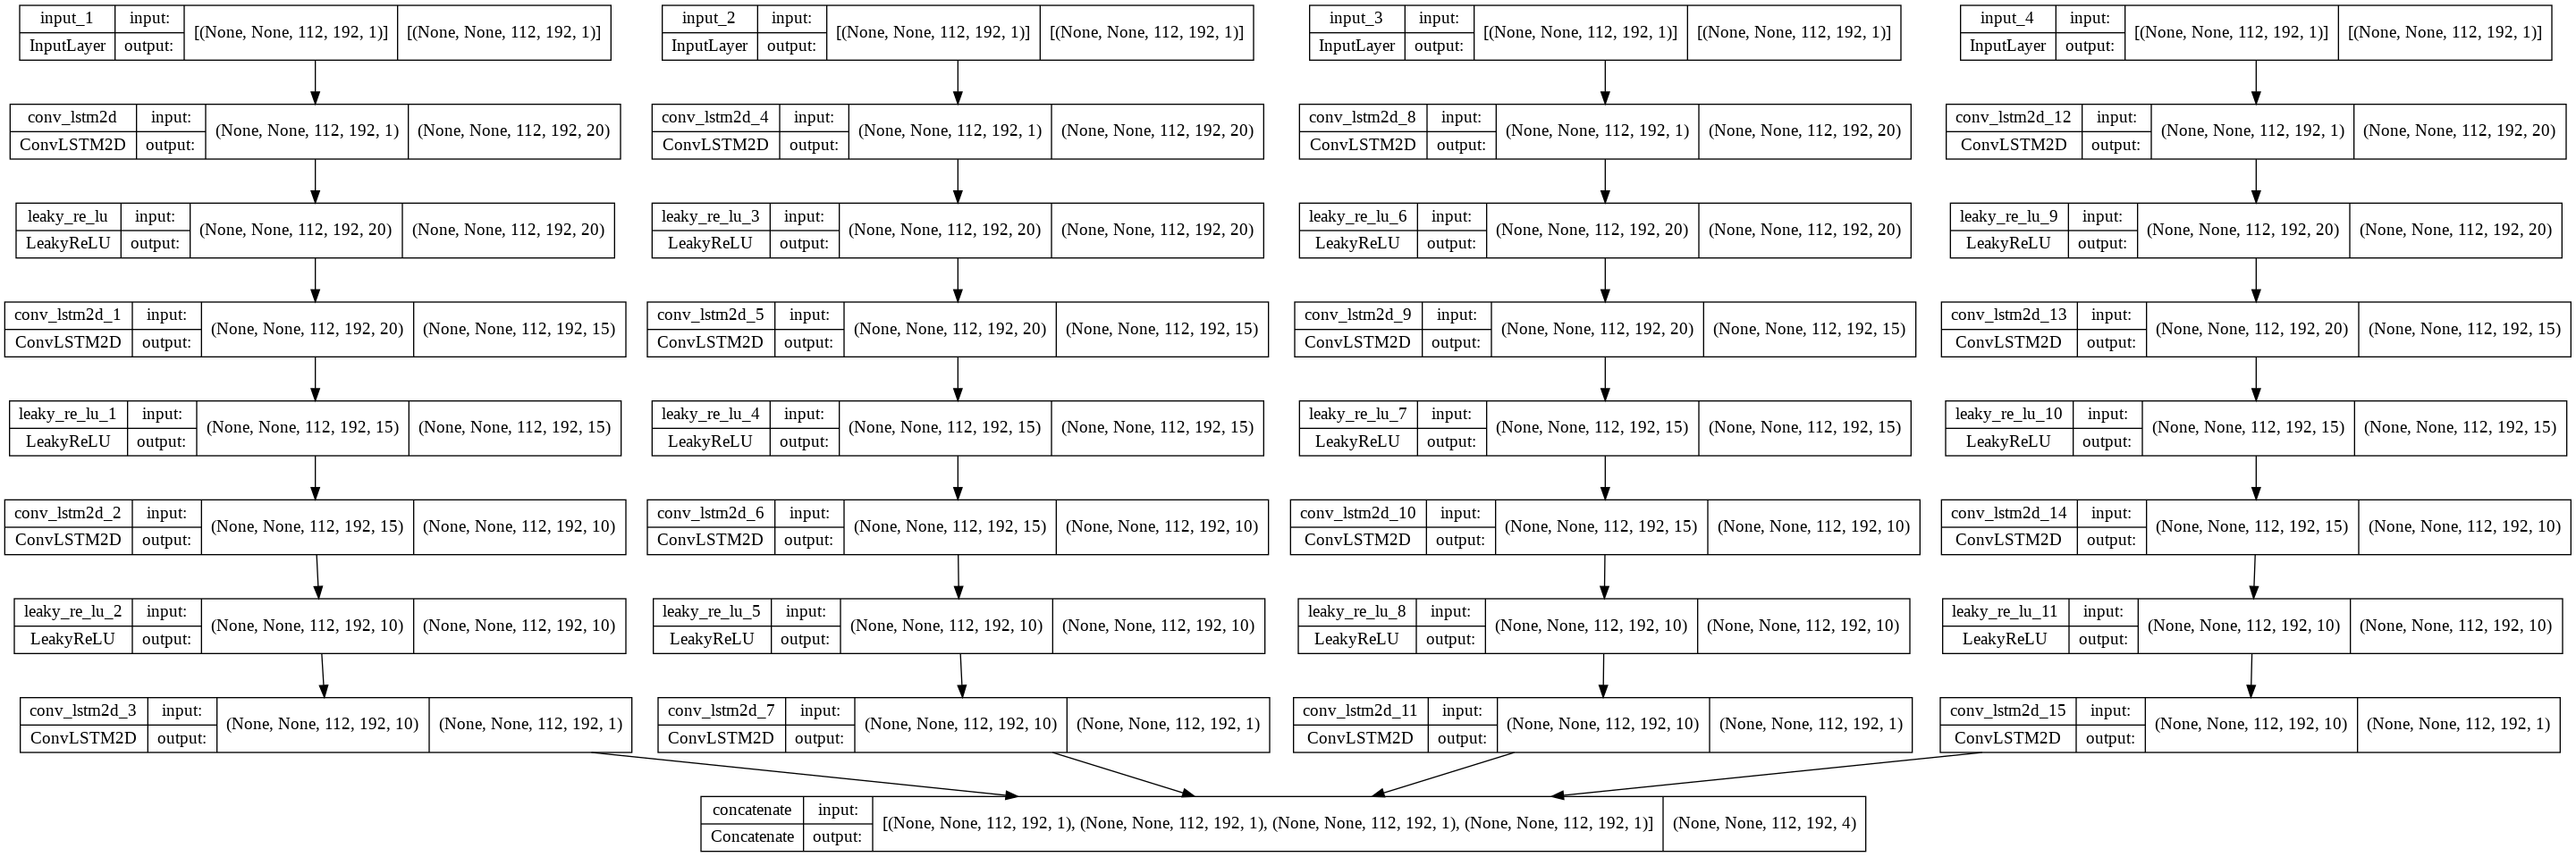

In [ ]:
with strategy.scope():
  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv3D` layer for the spatiotemporal outputs.
  inp1 = Input(shape=(None, 112, 192, 1))
  banch1 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU()(banch1)
  output1 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)

  inp2 = Input(shape=(None, 112, 192, 1))
  banch2 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU()(banch2)
  output2 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)

  inp3 = Input(shape=(None, 112, 192, 1))
  banch3 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU()(banch3)
  output3 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)

  inp4 = Input(shape=(None, 112, 192, 1))
  banch4 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU()(banch4)
  output4 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)

  #concatenate the four branch
  merging = Concatenate(axis=4)([output1, output2, output3, output4])

  multi_CNN12to12 = Model([inp1, inp2, inp3, inp4], merging)
  # multi_CNN12to12 = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_12to12.h5')
  multi_CNN12to12.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

# Next, we will build the complete model and compile it.
multi_CNN12to12.summary()

plot_model(multi_CNN12to12, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=30,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=30)
multi_CNN12to12.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [ ]:
start = time.time()
history = multi_CNN12to12.fit(
    [train[:, :, :, :, :1], train[:, :, :, :, 1:2], train[:, :, :, :, 2:3], train[:, :, :, :, 3:]],
    ytrain,
    batch_size = 3,
    epochs=60,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/60
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
143/143 [==============================] - 207s 1s/step - loss: 0.0337 - val_loss: 0.0085 - lr: 0.0010
Epoch 2/60
143/143 [==============================] - 150s 1s/step - loss: 0.0077 - val_loss: 0.0035 - lr: 0.0010
Epoch 3/60
143/143 [==============================] - 149s 1s/step - loss: 0.0053 - val_loss: 0.0023 - lr: 0.0010
Epoch 4/60
143/143 [==============================] - 150s 1s/step - loss: 0.0041 - val_loss: 0.0017 - lr: 0.0010
Epoch 5/60
143/143 [==============================] - 150s 1s/step - loss: 0.0035 - val_loss: 0.0015 - lr: 0.0010
Epoch 6/60
143/143 [==============================] - 150s 1s/step - loss: 0.0031 - val_loss: 0.0014 - lr: 0.0010
Epoch 7/60
143/143 [================

In [ ]:
print("______________ Loss plot of CAE + LSTM with 3 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(loss1)
plt.plot(valloss1)
plt.legend(['Loss', 'Val_loss']);

In [ ]:
multi_CNN12to12.save('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_12to12_v2.h5')
#multi_CNN12to12 = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_12to12.h5')

In [ ]:
predictions = multi_CNN12to12.predict([val[:, :, :, :, :1], val[:, :, :, :, 1:2], val[:, :, :, :, 2:3], val[:, :, :, :, 3:]])
# predictions = multi_CNN12to12.predict(val[:, :, :, :, :1])
# print("Shape of the predictions : ", predictions.shape)
preds= np.squeeze(predictions)

In [ ]:
preds.shape

(169, 12, 112, 192, 4)

In [ ]:
pred_train = np.asarray(multi_CNN12to12.predict([train[:40, :, :, :, :1], train[:40, :, :, :, 1:2], train[:40, :, :, :, 2:3], train[:40, :, :, :, 3:]]))
relative_mse_train = np.linalg.norm(pred_train - ytrain[0:40]) / (112*192)
print("____________ Training _____________")
print("Mse of prediction on training set : ", relative_mse_train)
print("Time for training : ", round(end - start, 3), "s")

relative_mse_test = np.linalg.norm(preds - yval)/ (112*192)
print("\n____________ Validation ___________")
print("Mse of prediction on validation set : ", relative_mse_test)

____________ Training _____________
Mse of prediction on training set :  0.007868796764146178
Time for training :  3802.242 s

____________ Validation ___________
Mse of prediction on validation set :  0.011218884117189794


### Multi var CNN LSTM 6 to 6

In [ ]:
#try for 3 months
X_train6to6_p1, Y_train6to6_p1 = Select_previous_future_months(d_previous_months=6, n_futur_months=6, data=multivar_data_p1)
X_train6to6_p2, Y_train6to6_p2 = Select_previous_future_months(d_previous_months=6, n_futur_months=6, data=multivar_data_p2)
X_train6to6_p3, Y_train6to6_p3 = Select_previous_future_months(d_previous_months=6, n_futur_months=6, data=multivar_data_p3)

In [ ]:
X_train6to6 = np.swapaxes(np.concatenate([X_train6to6_p1, X_train6to6_p2, X_train6to6_p3], axis=0), axis1=2, axis2=5)
Y_train6to6 = np.swapaxes(np.concatenate([Y_train6to6_p1, Y_train6to6_p2, Y_train6to6_p3], axis=0), axis1=2, axis2=5)

X_train6to6 = np.reshape(X_train6to6, newshape=(X_train6to6.shape[0], 6, 112, 192, 4))
Y_train6to6 = np.reshape(Y_train6to6, newshape=(Y_train6to6.shape[0], 6, 112, 192, 4))

In [ ]:
print("Shape of training set for 3 previous month : ", X_train6to6.shape, " and the one of its response : ", Y_train6to6.shape)

Shape of training set for 3 previous month :  (1047, 6, 112, 192, 4)  and the one of its response :  (1047, 6, 112, 192, 4)


In [ ]:
train, val, ytrain, yval = train_test_split(X_train6to6, Y_train6to6, test_size=0.25, random_state=123, shuffle=True)

In [ ]:
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data/train.npy', train)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data/ytrain.npy', ytrain)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data/val.npy', val)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data/yval.npy', yval)

In [ ]:
train = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data/train.npy', mmap_mode='r')
ytrain = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data/ytrain.npy', mmap_mode='r')
val = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data/val.npy', mmap_mode='r')
yval = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data/yval.npy', mmap_mode='r')

In [ ]:
print('_______ Training set _________ ')
print('Shape of X training : ', train.shape)
print('Shape of Y training : ', ytrain.shape)

print('\n_______ Validation set _________ ')
print('Shape of X validation : ', val.shape)
print('Shape of Y validation : ', yval.shape)

_______ Training set _________ 
Shape of X training :  (785, 6, 112, 192, 4)
Shape of Y training :  (785, 6, 112, 192, 4)

_______ Validation set _________ 
Shape of X validation :  (262, 6, 112, 192, 4)
Shape of Y validation :  (262, 6, 112, 192, 4)


In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                          
                                                                                                  
 input_2 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                          
                                                                                                  
 input_3 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                      

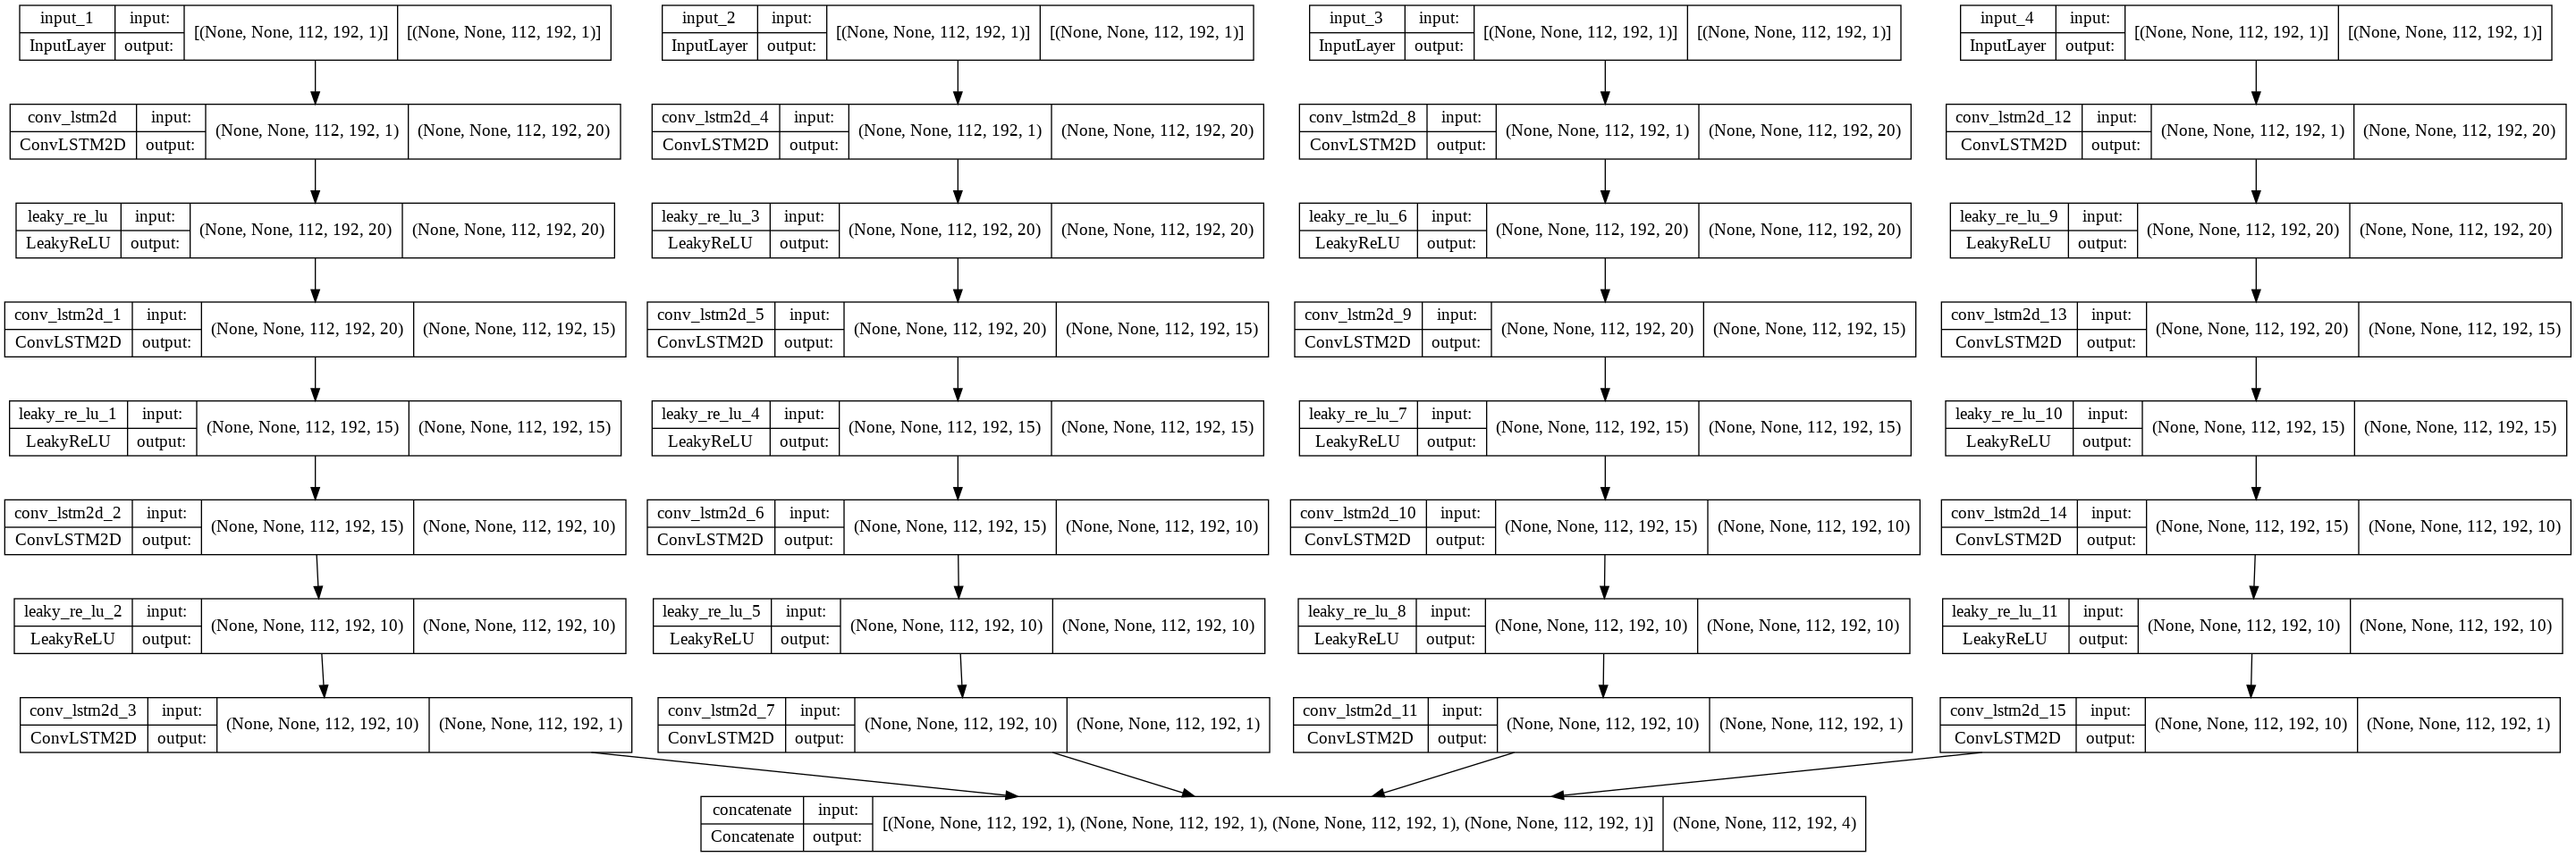

In [ ]:
with strategy.scope():
  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv3D` layer for the spatiotemporal outputs.
  inp1 = Input(shape=(None, 112, 192, 1))
  banch1 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU()(banch1)
  output1 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)

  inp2 = Input(shape=(None, 112, 192, 1))
  banch2 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU()(banch2)
  output2 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)

  inp3 = Input(shape=(None, 112, 192, 1))
  banch3 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU()(banch3)
  output3 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)

  inp4 = Input(shape=(None, 112, 192, 1))
  banch4 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU()(banch4)
  output4 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)

  #concatenate the four branch
  merging = Concatenate(axis=4)([output1, output2, output3, output4])

  # Next, we will build the complete model and compile it.
  multi_CNN6to6 = Model([inp1, inp2, inp3, inp4], merging)
  multi_CNN6to6.summary()

plot_model(multi_CNN6to6, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=30,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=30)
multi_CNN6to6.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [ ]:
start = time.time()
history = multi_CNN6to6.fit(
    [train[:, :, :, :, :1], train[:, :, :, :, 1:2], train[:, :, :, :, 2:3], train[:, :, :, :, 3:]],
    ytrain,
    batch_size = 3,
    epochs=60,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/60
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


223/223 [==============================] - ETA: 0s - loss: 0.0288INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


223/223 [==============================] - 228s 784ms/step - loss: 0.0288 - val_loss: 0.0065 - lr: 0.0010
Epoch 2/60
223/223 [==============================] - 161s 722ms/step - loss: 0.0078 - val_loss: 0.0036 - lr: 0.0010
Epoch 3/60
223/223 [==============================] - 159s 713ms/step - loss: 0.0058 - val_loss: 0.0027 - lr: 0.0010
Epoch 4/60
223/223 [==============================] - 159s 713ms/step - loss: 0.0048 - val_loss: 0.0021 - lr: 0.0010
Epoch 5/60
223/223 [==============================] - 159s 714ms/step - loss: 0.0041 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/60
223/223 [==============================] - 159s 712ms/step - loss: 0.0036 - val_loss: 0.0016 - lr: 0.0010
Epoch 7/60
223/223 [==============================] - 159s 715ms/step - loss: 0.0033 - val_loss: 0.0016 - lr: 0.0010
Epoch 8/60
223/223 [==============================] - 159s 713ms/step - loss: 0.0031 - val_loss: 0.0015 - lr: 0.0010
Epoch 9/60
223/223 [==============================] - 159s 713ms/step - los

______________ Loss plot of CAE + LSTM with 3 months as inputs__________________



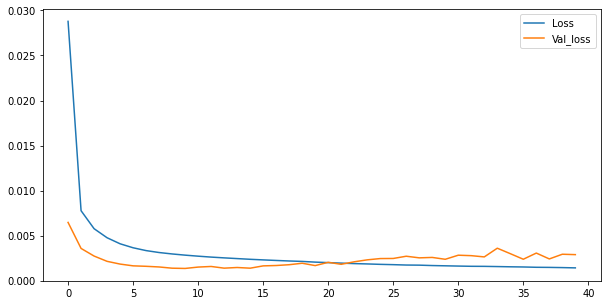

In [ ]:
print("______________ Loss plot of CAE + LSTM with 3 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
loss1 = history.history['loss']
valloss1 = history.history['val_loss']

In [ ]:
multi_CNN6to6.save('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_6to6.h5')
#multi_CNN6to6 = load_model('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_6to6.h5')

In [ ]:
predictions = multi_CNN6to6.predict([val[:, :, :, :, :1], val[:, :, :, :, 1:2], val[:, :, :, :, 2:3], val[:, :, :, :, 3:]])
# predictions = multi_CNN6to6.predict(val[:, :, :, :, :1])
# print("Shape of the predictions : ", predictions.shape)
preds= np.squeeze(predictions)

In [ ]:
preds.shape

(150, 6, 112, 192, 4)

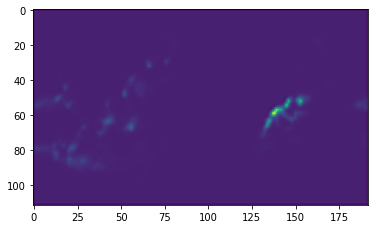

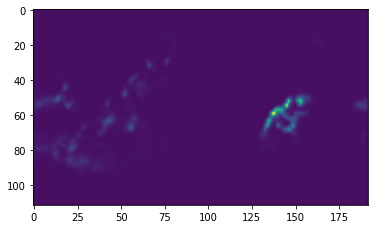

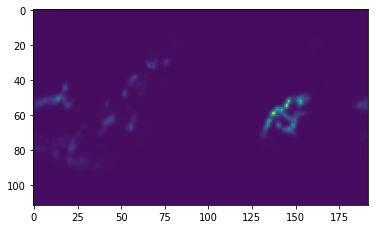

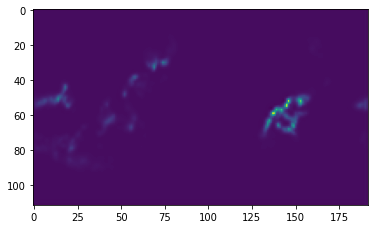

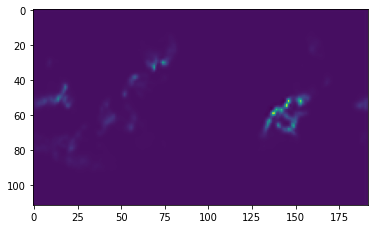

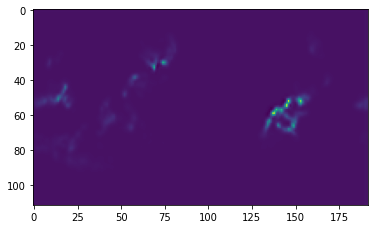

In [ ]:
plt.show(plt.imshow(preds[10, 0, :, :, 0]))
plt.show(plt.imshow(preds[10, 1, :, :, 0]))
plt.show(plt.imshow(preds[10, 2, :, :, 0]))
plt.show(plt.imshow(preds[10, 3, :, :, 0]))
plt.show(plt.imshow(preds[10, 4, :, :, 0]))
plt.show(plt.imshow(preds[10, 5, :, :, 0]))

In [ ]:
pred_train = np.asarray(multi_CNN6to6.predict([train[:40, :, :, :, :1], train[:40, :, :, :, 1:2], train[:40, :, :, :, 2:3], train[:40, :, :, :, 3:]]))
relative_mse_train = np.linalg.norm(pred_train - ytrain[0:40]) / (112*192)
print("____________ Training _____________")
print("Mse of prediction on training set : ", relative_mse_train)
print("Time for training : ", round(end - start, 3), "s")

relative_mse_test = np.linalg.norm(preds - yval)/ (112*192)
print("\n____________ Validation ___________")
print("Mse of prediction on validation set : ", relative_mse_test)

____________ Training _____________
Mse of prediction on training set :  0.005551484310402978
Time for training :  1035.291 s

____________ Validation ___________
Mse of prediction on validation set :  0.010725461895752056


### Multi var CNN LSTM 3 to 3

In [ ]:
X_train3to3_p1, Y_train3to3_p1 = Select_previous_future_months(d_previous_months=3, n_futur_months=3, data=multivar_data_p1)
X_train3to3_p2, Y_train3to3_p2 = Select_previous_future_months(d_previous_months=3, n_futur_months=3, data=multivar_data_p2)
X_train3to3_p3, Y_train3to3_p3 = Select_previous_future_months(d_previous_months=3, n_futur_months=3, data=multivar_data_p3)

In [ ]:
X_train3to3 = np.swapaxes(np.concatenate([X_train3to3_p1, X_train3to3_p2, X_train3to3_p3], axis=0), axis1=2, axis2=5)
Y_train3to3 = np.swapaxes(np.concatenate([Y_train3to3_p1, Y_train3to3_p2, Y_train3to3_p3], axis=0), axis1=2, axis2=5)

In [ ]:
X_train3to3 = np.reshape(X_train3to3, newshape=(X_train3to3.shape[0], 3, 112, 192, 4))
Y_train3to3 = np.reshape(Y_train3to3, newshape=(Y_train3to3.shape[0], 3, 112, 192, 4))

In [ ]:
#try for 3 months
X_train3to3_p1, Y_train3to3_p1 = Select_previous_future_months(d_previous_months=3, n_futur_months=3, data=multivar_data_p1)
X_train3to3_p2, Y_train3to3_p2 = Select_previous_future_months(d_previous_months=3, n_futur_months=3, data=multivar_data_p2)
X_train3to3_p3, Y_train3to3_p3 = Select_previous_future_months(d_previous_months=3, n_futur_months=3, data=multivar_data_p3)

X_train3to3 = np.swapaxes(np.concatenate([X_train3to3_p1[l1], X_train3to3_p2[l2], X_train3to3_p3[l3]], axis=0), axis1=2, axis2=5)
Y_train3to3 = np.swapaxes(np.concatenate([Y_train3to3_p1[l1], Y_train3to3_p2[l2], Y_train3to3_p3[l3]], axis=0), axis1=2, axis2=5)

X_train3to3 = np.reshape(X_train3to3, newshape=(X_train3to3.shape[0], 3, 112, 192, 4))
Y_train3to3 = np.reshape(Y_train3to3, newshape=(Y_train3to3.shape[0], 3, 112, 192, 4))

In [ ]:
print("Shape of training set for 3 previous month : ", X_train3to3.shape, " and the one of its response : ", Y_train3to3.shape)

Shape of training set for 3 previous month :  (1065, 3, 112, 192, 4)  and the one of its response :  (1065, 3, 112, 192, 4)


In [ ]:
train, val, ytrain, yval = train_test_split(X_train3to3, Y_train3to3, test_size=0.25, random_state=123, shuffle=True)

In [ ]:
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data3/train.npy', train)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data3/ytrain.npy', ytrain)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data3/val.npy', val)
np.save('/content/drive/MyDrive/Wildfires_IRP/notebooks/data3/yval.npy', yval)

In [ ]:
train = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data3/train.npy', mmap_mode='r')
ytrain = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data3/ytrain.npy', mmap_mode='r')
val = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data3/val.npy', mmap_mode='r')
yval = np.load('/content/drive/MyDrive/Wildfires_IRP/notebooks/data3/yval.npy', mmap_mode='r')

In [ ]:
print('_______ Training set _________ ')
print('Shape of X training : ', train.shape)
print('Shape of Y training : ', ytrain.shape)

print('\n_______ Validation set _________ ')
print('Shape of X validation : ', val.shape)
print('Shape of Y validation : ', yval.shape)

_______ Training set _________ 
Shape of X training :  (798, 3, 112, 192, 4)
Shape of Y training :  (798, 3, 112, 192, 4)

_______ Validation set _________ 
Shape of X validation :  (267, 3, 112, 192, 4)
Shape of Y validation :  (267, 3, 112, 192, 4)


In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Number of devices: 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                          
                                                                                                  
 input_2 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                          
                                                                                                  
 input_3 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                      

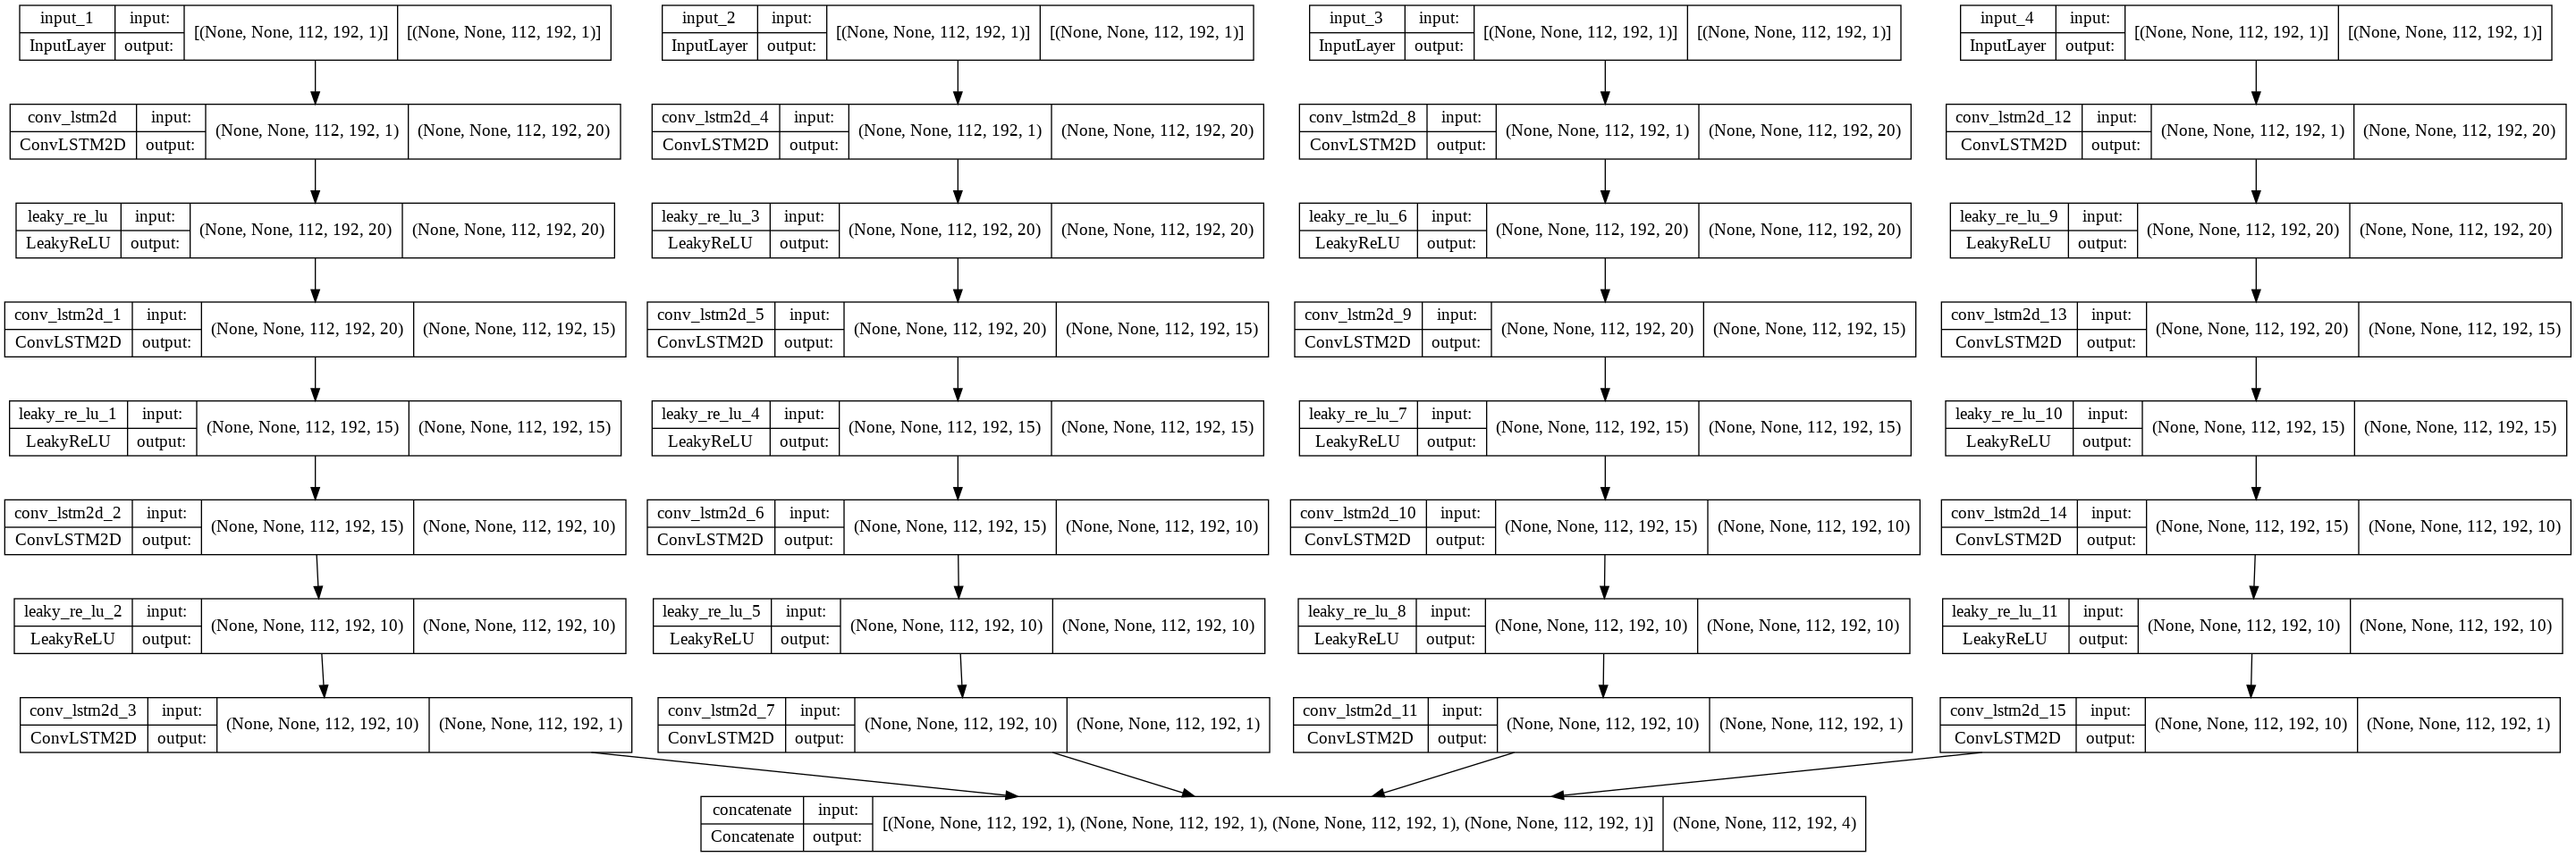

In [ ]:
with strategy.scope():
  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv3D` layer for the spatiotemporal outputs.
  inp1 = Input(shape=(None, 112, 192, 1))
  banch1 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU()(banch1)
  output1 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)

  inp2 = Input(shape=(None, 112, 192, 1))
  banch2 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU()(banch2)
  output2 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)

  inp3 = Input(shape=(None, 112, 192, 1))
  banch3 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU()(banch3)
  output3 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)

  inp4 = Input(shape=(None, 112, 192, 1))
  banch4 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU()(banch4)
  output4 = ConvLSTM2D(filters=1, kernel_size=(1, 1), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)

  #concatenate the four branch
  merging = Concatenate(axis=4)([output1, output2, output3, output4])

  # Next, we will build the complete model and compile it.
  multi_CNN3to3 = Model([inp1, inp2, inp3, inp4], merging)
  multi_CNN3to3.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

multi_CNN3to3.summary()

plot_model(multi_CNN3to3, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=30,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=30)

In [ ]:
start = time.time()
history = multi_CNN3to3.fit(
    [train[:, :, :, :, :1], train[:, :, :, :, 1:2], train[:, :, :, :, 2:3], train[:, :, :, :, 3:]],
    ytrain,
    batch_size = 3,
    epochs=60,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/60
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


226/226 [==============================] - ETA: 0s - loss: 0.0378INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


226/226 [==============================] - 97s 300ms/step - loss: 0.0378 - val_loss: 0.0081 - lr: 0.0010
Epoch 2/60
226/226 [==============================] - 60s 267ms/step - loss: 0.0103 - val_loss: 0.0049 - lr: 0.0010
Epoch 3/60
226/226 [==============================] - 60s 266ms/step - loss: 0.0076 - val_loss: 0.0032 - lr: 0.0010
Epoch 4/60
226/226 [==============================] - 60s 266ms/step - loss: 0.0060 - val_loss: 0.0023 - lr: 0.0010
Epoch 5/60
226/226 [==============================] - 60s 266ms/step - loss: 0.0051 - val_loss: 0.0019 - lr: 0.0010
Epoch 6/60
226/226 [==============================] - 60s 266ms/step - loss: 0.0045 - val_loss: 0.0018 - lr: 0.0010
Epoch 7/60
226/226 [==============================] - 60s 266ms/step - loss: 0.0041 - val_loss: 0.0016 - lr: 0.0010
Epoch 8/60
226/226 [==============================] - 60s 266ms/step - loss: 0.0039 - val_loss: 0.0016 - lr: 0.0010
Epoch 9/60
226/226 [==============================] - 60s 266ms/step - loss: 0.0036

In [ ]:
multi_CNN3to3.save('/content/drive/MyDrive/Wildfires_IRP/model/Multi_CNN_LSTM/multi_CNN_LSTM_3to3.h5')

______________ Loss plot of CAE + LSTM with 3 months as inputs__________________



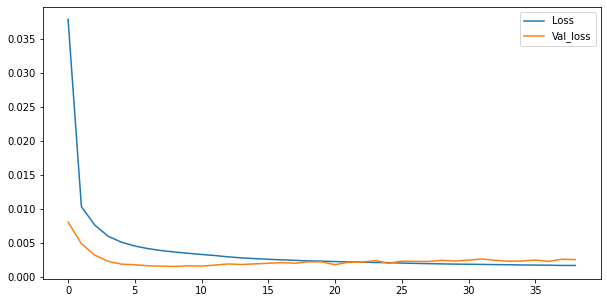

In [ ]:
print("______________ Loss plot of CAE + LSTM with 3 months as inputs__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
pred_train = np.asarray(multi_CNN3to3.predict([train[:40, :, :, :, :1], train[:40, :, :, :, 1:2], train[:40, :, :, :, 2:3], train[:40, :, :, :, 3:]]))
relative_mse_train = np.linalg.norm(pred_train - ytrain[0:40]) / (112*192)
print("____________ Training _____________")
print("Mse of prediction on training set : ", relative_mse_train)
print("Time for training : ", round(end - start, 3), "s")

relative_mse_test = np.linalg.norm(preds - yval)/ (112*192)
print("\n____________ Validation ___________")
print("Mse of prediction on validation set : ", relative_mse_test)

____________ Training _____________
Mse of prediction on training set :  0.005551484310402978
Time for training :  1035.291 s

____________ Validation ___________
Mse of prediction on validation set :  0.010725461895752056


# Appendix - Unsuccessful tests

##### Test multi head multi cnn lstm 3to3

**This techniques take sthe multiple variables concatenate and split them into 4 channels treated separately until concatenating the predictions in the final layers**

In [ ]:
X_train3m3, Y_train3m3 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=multivar_data_p1)
# X_train12m_p2, Y_train12m_p2 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=multivar_data_p2)
# X_train12m_p3, Y_train12m_p3 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=multivar_data_p3)

# X_train12m12 = np.concatenate([X_train12m_p1[l1], X_train12m_p2[l2], X_train12m_p3[l3]], axis=0)
# Y_train12m12 = np.concatenate([Y_train12m_p1[l1], Y_train12m_p2[l2], Y_train12m_p3[l3]], axis=0)

X_train3m3 = np.squeeze(np.swapaxes(X_train3m3, axis1=2, axis2=5))
Y_train3m3 = np.squeeze(np.swapaxes(Y_train3m3, axis1=2, axis2=5))

In [ ]:
print(X_train3m3.shape)
print(Y_train3m3.shape)

(277, 12, 112, 192, 4)
(277, 12, 112, 192, 4)


In [ ]:
train, val, ytrain, yval = train_test_split(X_train3m3, Y_train3m3, test_size=0.25, random_state=123)

In [ ]:
print('__________training___________')
print(train.shape)
print(ytrain.shape)

print('\n__________testing___________')
print(val.shape)
print(yval.shape)

__________training___________
(221, 3, 112, 192, 4)
(221, 3, 112, 192, 4)

__________testing___________
(74, 3, 112, 192, 4)
(74, 3, 112, 192, 4)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, None, 112,   0           []                               
                                192, 4)]                                                          
                                                                                                  
 conv_lstm2d_126 (ConvLSTM2D)   (None, None, 112, 1  17360       ['input_41[0][0]']               
                                92, 20)                                                           
                                                                                                  
 conv_lstm2d_129 (ConvLSTM2D)   (None, None, 112, 1  17360       ['input_41[0][0]']               
                                92, 20)                                                     

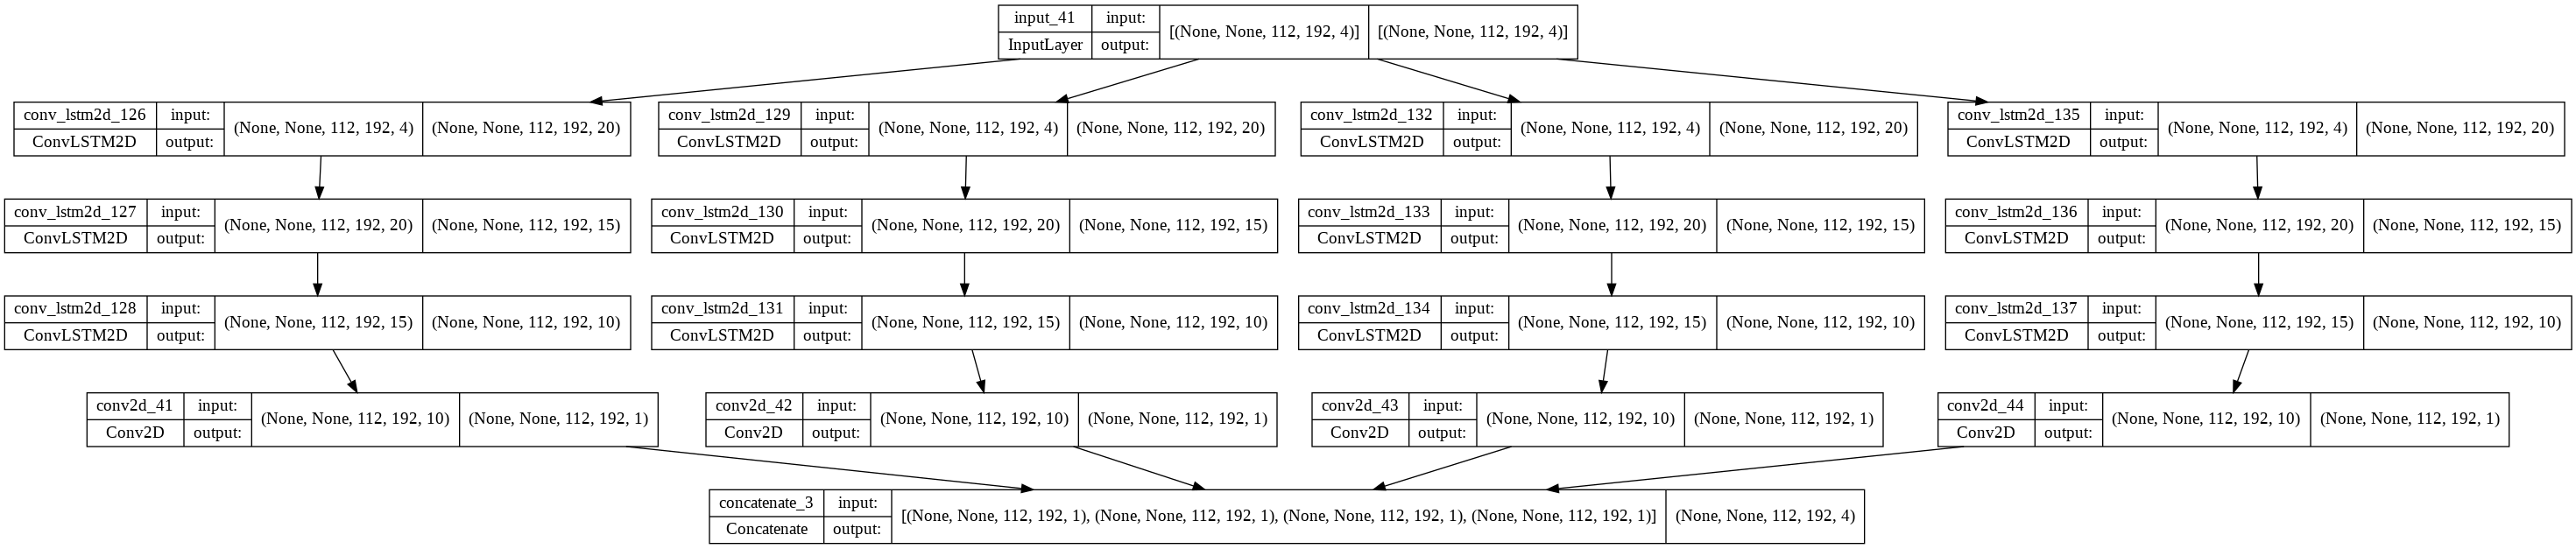

In [ ]:
from keras.layers import Concatenate
from tensorflow.keras.utils import plot_model

inp = Input(shape=(None, *train.shape[2:]))

head_list = []

for i in range(0, 4):
  conv_layer_head = ConvLSTM2D(filters=20, kernel_size=(3,3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp)
  conv_layer_head_2 = ConvLSTM2D(filters=15, kernel_size=(3,3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(conv_layer_head)
  conv_layer_flatten = ConvLSTM2D(filters=10, kernel_size=(3,3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(conv_layer_head_2)
  final_conv_layer = Conv2D(filters=1, kernel_size=(3,3), activation="elu", padding="same")(conv_layer_flatten)
  head_list.append(final_conv_layer)
  
concat_cnn = Concatenate(axis=4)(head_list)

multi_head_cnn_lstm_model_v1 = Model(inputs=inp, outputs=concat_cnn)
multi_head_cnn_lstm_model_v1.summary()

plot_model(multi_head_cnn_lstm_model_v1, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=15,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=15)
multi_head_cnn_lstm_model_v1.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

In [ ]:
start = time.time()
history = multi_head_cnn_lstm_model_v1.fit(
    train[0:50],
    ytrain[0:50],
    batch_size = 3,
    epochs=20,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/20
14/14 [==============================] - 36s 1s/step - loss: 0.0638 - val_loss: 0.0407 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 13s 959ms/step - loss: 0.0316 - val_loss: 0.0238 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 13s 958ms/step - loss: 0.0211 - val_loss: 0.0168 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - 13s 958ms/step - loss: 0.0153 - val_loss: 0.0122 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 13s 958ms/step - loss: 0.0117 - val_loss: 0.0093 - lr: 0.0010
Epoch 6/20
14/14 [==============================] - 13s 961ms/step - loss: 0.0093 - val_loss: 0.0073 - lr: 0.0010
Epoch 7/20
14/14 [==============================] - 13s 959ms/step - loss: 0.0078 - val_loss: 0.0061 - lr: 0.0010
Epoch 8/20
14/14 [==============================] - 13s 957ms/step - loss: 0.0070 - val_loss: 0.0054 - lr: 0.0010
Epoch 9/20
14/14 [==============================] - 13s 957ms/step - loss: 0.0064 - val_los

______________ Loss plot of Multi CNN lstm model__________________



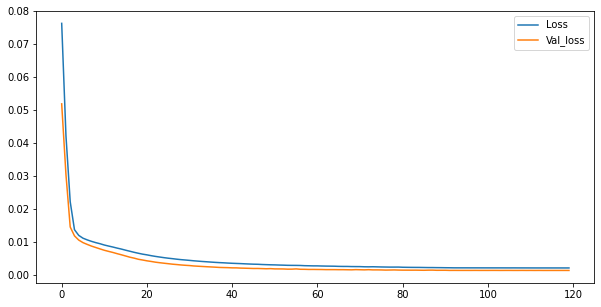

In [ ]:
print("______________ Loss plot of Multi CNN lstm model__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
predictions_v1 = multi_head_cnn_lstm_model_v1(val)

In [ ]:
predictions_v1.shape

TensorShape([70, 12, 112, 192, 4])

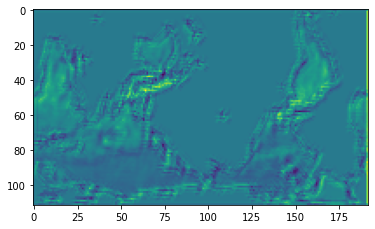

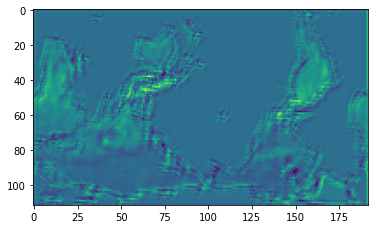

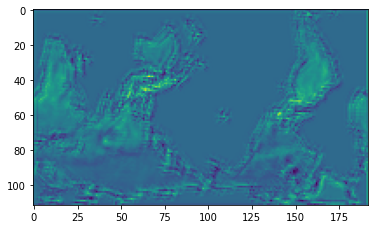

In [ ]:
plt.show(plt.imshow(predictions_v1[0, 0, :, :, 0]))
plt.show(plt.imshow(predictions_v1[0, 1, :, :, 0]))
plt.show(plt.imshow(predictions_v1[0, 2, :, :, 0]))

##### Test multi headed multi convlst 3to3 _ 2

**This techniques treats the concatenate variables all together until splitting them in the last layers into 4 separate predictions**

In [ ]:
X_train3m3, Y_train3m3 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=multivar_data_p1)
# X_train12m_p2, Y_train12m_p2 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=multivar_data_p2)
# X_train12m_p3, Y_train12m_p3 = Select_previous_future_months(d_previous_months=12, n_futur_months=12, data=multivar_data_p3)

# X_train12m12 = np.concatenate([X_train12m_p1[l1], X_train12m_p2[l2], X_train12m_p3[l3]], axis=0)
# Y_train12m12 = np.concatenate([Y_train12m_p1[l1], Y_train12m_p2[l2], Y_train12m_p3[l3]], axis=0)

X_train3m3 = np.squeeze(np.swapaxes(X_train3m3, axis1=2, axis2=5))
Y_train3m3 = np.squeeze(np.swapaxes(Y_train3m3, axis1=2, axis2=5))

In [ ]:
print(X_train3m3.shape)
print(Y_train3m3.shape)

(277, 12, 112, 192, 4)
(277, 12, 112, 192, 4)


In [ ]:
train, val, ytrain, yval = train_test_split(X_train3m3, Y_train3m3, test_size=0.25, random_state=123)

In [ ]:
print('__________training___________')
print(train.shape)
print(ytrain.shape)

print('\n__________testing___________')
print(val.shape)
print(yval.shape)

__________training___________
(221, 3, 112, 192, 4)
(221, 3, 112, 192, 4)

__________testing___________
(74, 3, 112, 192, 4)
(74, 3, 112, 192, 4)


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None, None, 112,   0           []                               
                                192, 4)]                                                          
                                                                                                  
 conv_lstm2d_138 (ConvLSTM2D)   (None, None, 112, 1  17360       ['input_42[0][0]']               
                                92, 20)                                                           
                                                                                                  
 leaky_re_lu_112 (LeakyReLU)    (None, None, 112, 1  0           ['conv_lstm2d_138[0][0]']        
                                92, 20)                                                     

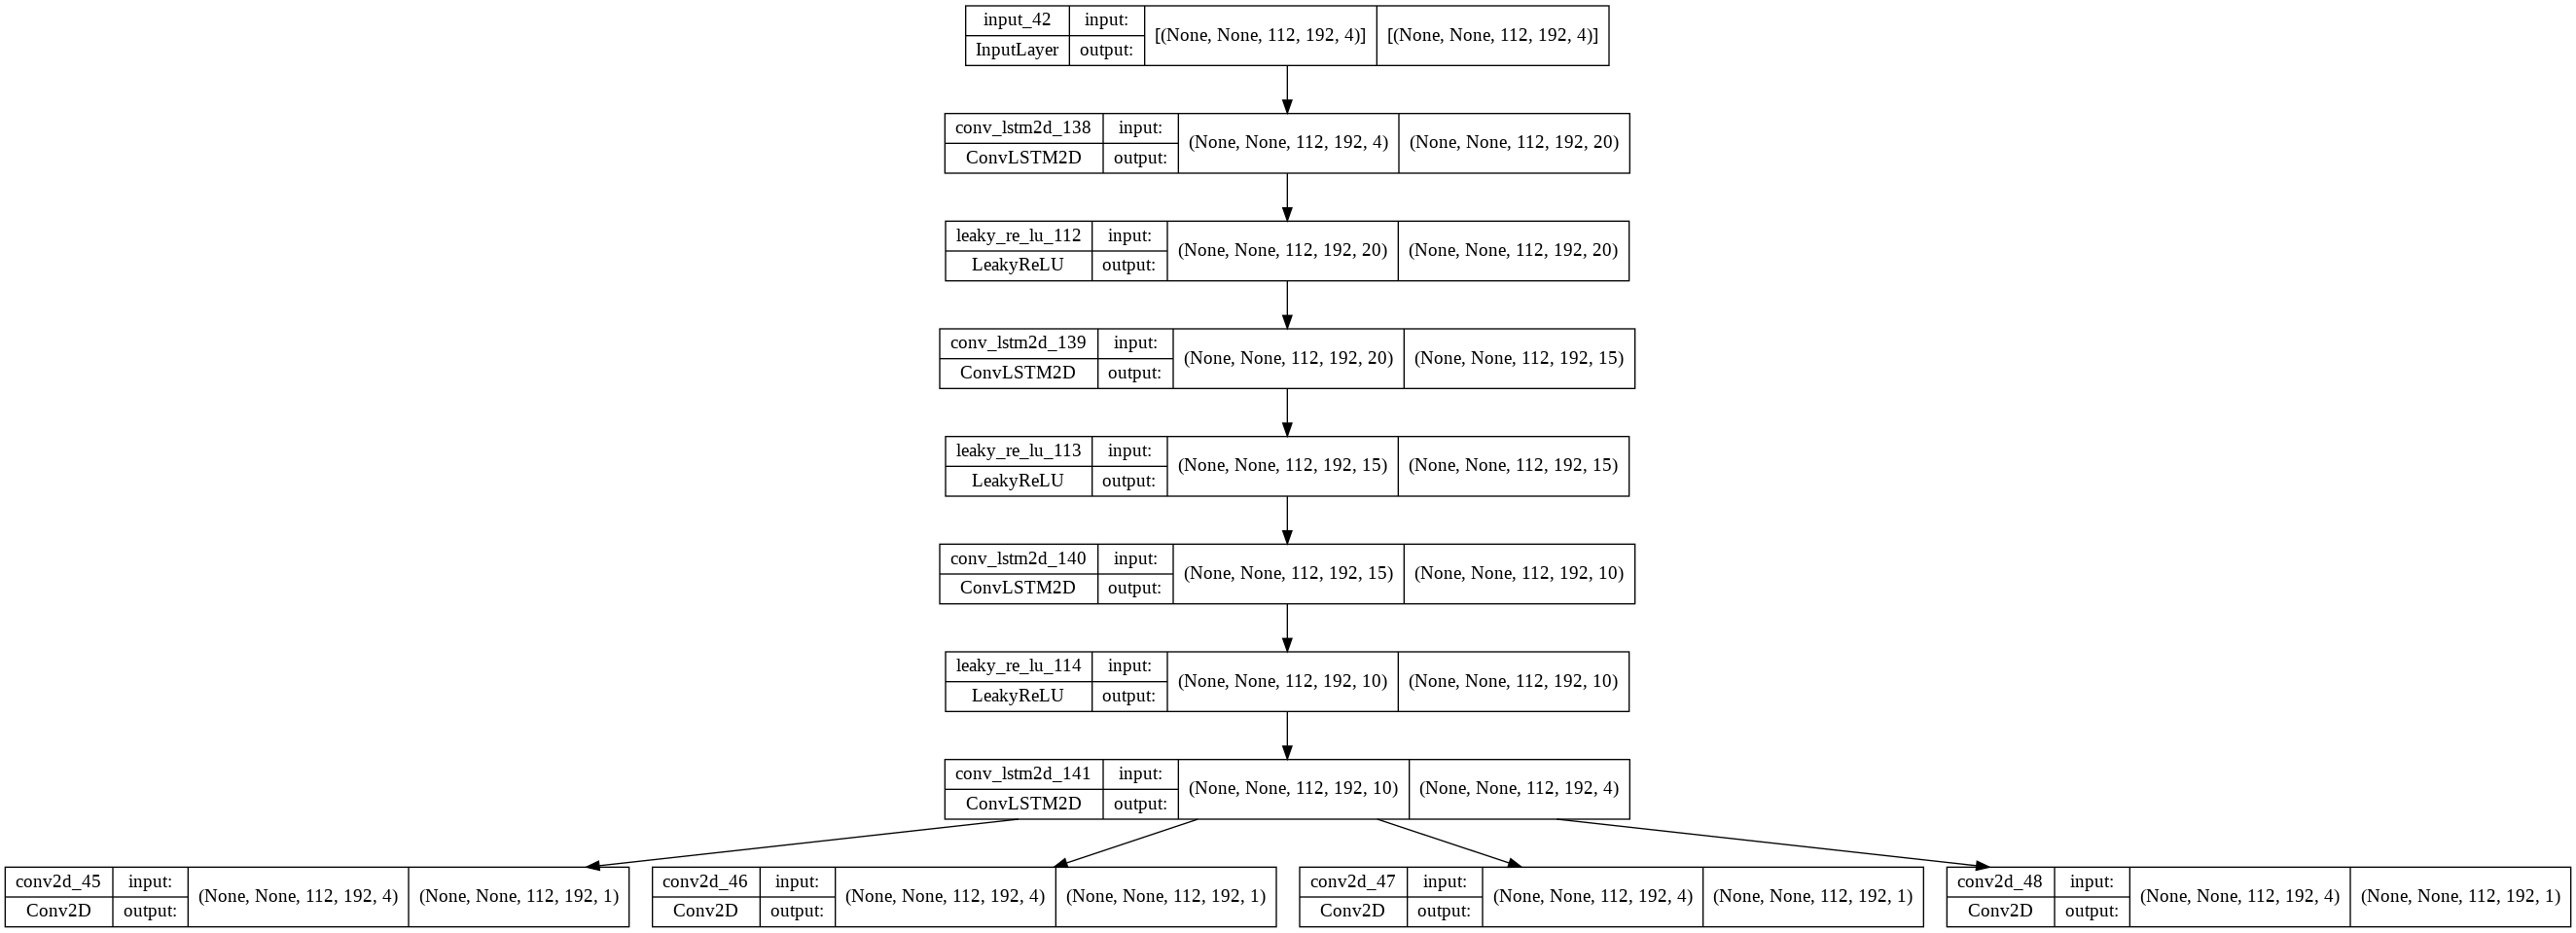

In [ ]:
inp = Input(shape=(None, *train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp)
# x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
# x = MaxPooling3D((1,1,1))(x)

x = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(x)
# x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
# x = MaxPooling3D((1,1,1))(x)

x = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(x)
# x = BatchNormalization()(x)
x = LeakyReLU()(x)
# x = MaxPooling3D((1,1,1))(x)

# x = ConvLSTM2D(filters=64, kernel_size=(2, 2), padding="same", return_sequences=True, activation="relu", dropout=0.2)(x)
# # x = BatchNormalization()(x)
# x = LeakyReLU()(x)

x = ConvLSTM2D(filters=4, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(x)
# x = Reshape((4, 112, 192, 1))(x)

output1 = Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation="elu")(x)
output2 = Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation="elu")(x)
output3 = Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation="elu")(x)
output4 = Conv2D(filters=1, kernel_size=(3, 3), padding="same", activation="elu")(x)

# Next, we will build the complete model and compile it.
multi_headed_multi_CNN3to3_v2 = Model(inp, [output1, output2, output3, output4])
multi_headed_multi_CNN3to3_v2.summary()
plot_model(multi_headed_multi_CNN3to3_v2, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=15,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=15)
multi_headed_multi_CNN3to3_v2.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

In [ ]:
start = time.time()
history = multi_headed_multi_CNN3to3_v2.fit(
    train,
    [ytrain[:, :, :, :, :1], ytrain[:, :, :, :, 1:2], ytrain[:, :, :, :, 2:3], ytrain[:, :, :, :, 3:]],
    batch_size = 3,
    epochs=40,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/40
59/59 [==============================] - 23s 397ms/step - loss: 0.0095 - conv2d_45_loss: 1.2136e-04 - conv2d_46_loss: 0.0041 - conv2d_47_loss: 0.0028 - conv2d_48_loss: 0.0025 - val_loss: 0.0061 - val_conv2d_45_loss: 8.7929e-05 - val_conv2d_46_loss: 0.0029 - val_conv2d_47_loss: 0.0014 - val_conv2d_48_loss: 0.0017 - lr: 0.0010
Epoch 2/40
59/59 [==============================] - 23s 384ms/step - loss: 0.0093 - conv2d_45_loss: 1.1095e-04 - conv2d_46_loss: 0.0040 - conv2d_47_loss: 0.0027 - conv2d_48_loss: 0.0024 - val_loss: 0.0059 - val_conv2d_45_loss: 8.0689e-05 - val_conv2d_46_loss: 0.0029 - val_conv2d_47_loss: 0.0013 - val_conv2d_48_loss: 0.0016 - lr: 0.0010
Epoch 3/40
59/59 [==============================] - 23s 383ms/step - loss: 0.0090 - conv2d_45_loss: 1.0181e-04 - conv2d_46_loss: 0.0039 - conv2d_47_loss: 0.0026 - conv2d_48_loss: 0.0023 - val_loss: 0.0057 - val_conv2d_45_loss: 7.4833e-05 - val_conv2d_46_loss: 0.0028 - val_conv2d_47_loss: 0.0013 - val_conv2d_48_loss: 0.0016

______________ Loss plot of Multi CNN lstm model__________________



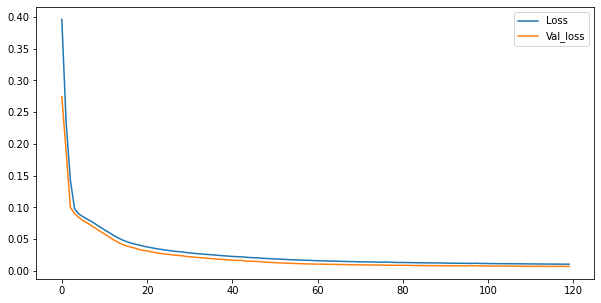

In [ ]:
print("______________ Loss plot of Multi CNN lstm model__________________\n")
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Val_loss']);

In [ ]:
predictions_v2 = multi_headed_multi_CNN3to3_v2.predict(val)
preds_v2 = np.squeeze(np.swapaxes(np.asarray(predictions_v2), axis1=0, axis2=5))
print('Shape of predictions : ' , preds_v2.shape)

Shape of predictions :  (70, 12, 112, 192, 4)


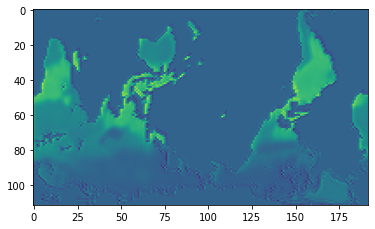

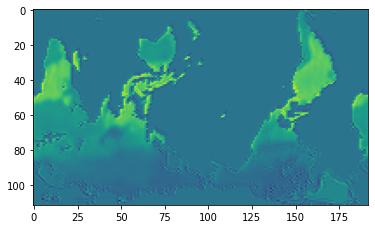

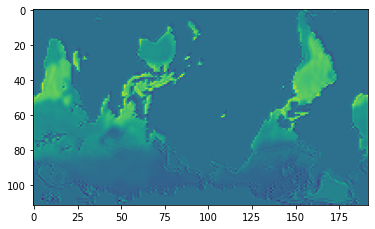

In [ ]:
plt.show(plt.imshow(preds_v2[0, 0, :, :, 0]))
plt.show(plt.imshow(preds_v2[0, 1, :, :, 0]))
plt.show(plt.imshow(preds_v2[0, 2, :, :, 0]))

##### Test One head ConvLSTM

**This techniques use a classic CONVLSTM model using multichannels and sharing informations all along training.**

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, 112, 192,   0         
                             4)]                                 
                                                                 
 conv_lstm2d_33 (ConvLSTM2D)  (None, None, 112, 192, 4  112800   
                             0)                                  
                                                                 
 batch_normalization_9 (Batc  (None, None, 112, 192, 4  160      
 hNormalization)             0)                                  
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, None, 112, 192, 4  0         
                             0)                                  
                                                                 
 conv_lstm2d_34 (ConvLSTM2D)  (None, None, 112, 192, 3  134

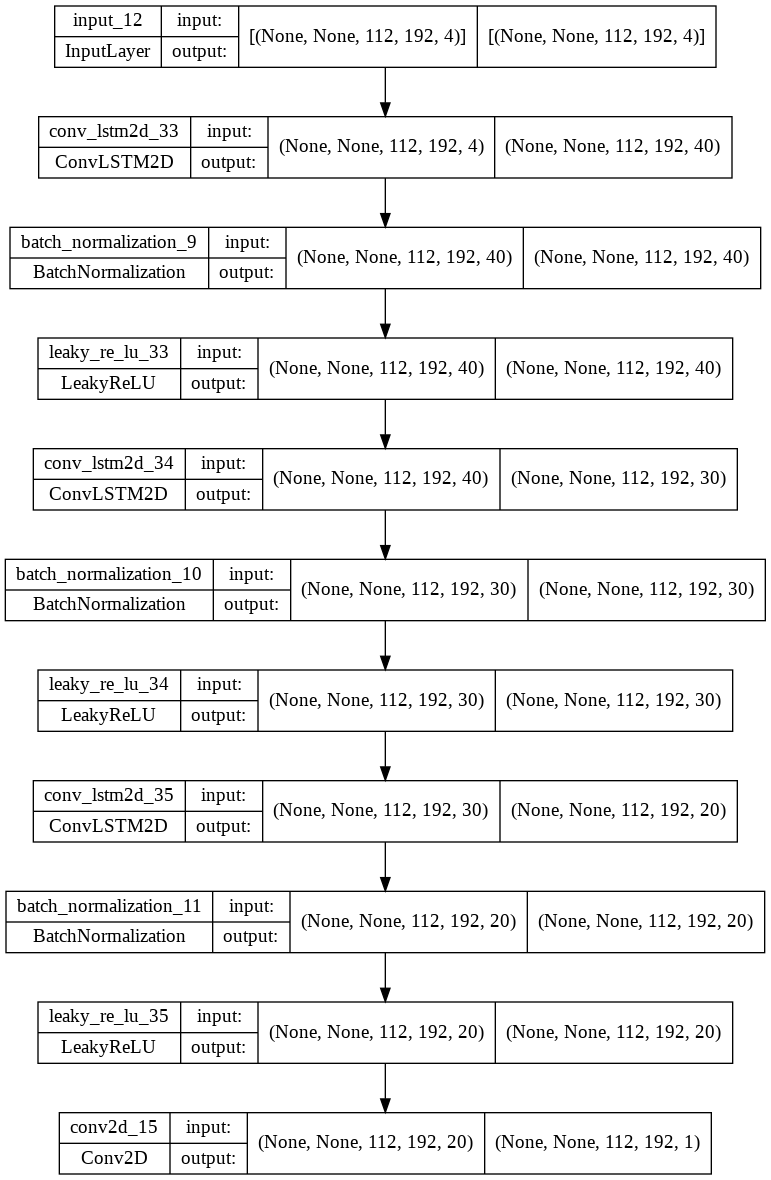

In [ ]:
with strategy.scope():
  # Construct the input layer with no definite frame size.
  inp = Input(shape=(None, *train.shape[2:]))

  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv3D` layer for the spatiotemporal outputs.
  x = ConvLSTM2D(filters=40, kernel_size=(4, 4), padding="same", return_sequences=True, activation="relu", dropout=0.2)(inp)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)

  x = ConvLSTM2D(filters=30, kernel_size=(4, 4), padding="same", return_sequences=True, activation="relu", dropout=0.2)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)

  x = ConvLSTM2D(filters=20, kernel_size=(4, 4), padding="same", return_sequences=True, activation="relu", dropout=0.2)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  # x = ConvLSTM2D(filters=64, kernel_size=(2, 2), padding="same", return_sequences=True, activation="relu", dropout=0.2)(x)
  # x = BatchNormalization()(x)
  # x = LeakyReLU()(x)

  # Final layer to combine the features
  FL = Conv2D(filters=1, kernel_size=(5, 5), activation="elu", padding="same")(x)
  # final_output = Conv2D(filters=4, kernel_size=(5, 5), activation="elu", padding="same")(FL)

  # Next, we will build the complete model and compile it.
  CNN12to1 = Model(inp, FL)
  CNN12to1.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

CNN12to1.summary()
plot_model(CNN12to1, show_shapes=True)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=20,
                                               verbose=1,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20)

In [ ]:
start = time.time()
history = CNN12to1.fit(
    train[l],
    ytrain[l, :, :, :, :1],
    batch_size = 3,
    epochs=30,
    validation_split=0.15,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/30
17/17 [==============================] - 23s 893ms/step - loss: 0.1237 - val_loss: 0.0452 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - 13s 770ms/step - loss: 0.0137 - val_loss: 0.0097 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - 13s 770ms/step - loss: 0.0174 - val_loss: 0.0018 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - 13s 770ms/step - loss: 0.0176 - val_loss: 0.0016 - lr: 0.0010
Epoch 5/30
17/17 [==============================] - 13s 770ms/step - loss: 0.0145 - val_loss: 3.9405e-04 - lr: 0.0010
Epoch 6/30
17/17 [==============================] - 13s 770ms/step - loss: 0.0144 - val_loss: 1.3760e-04 - lr: 0.0010
Epoch 7/30
17/17 [==============================] - 13s 769ms/step - loss: 0.0237 - val_loss: 2.6785e-04 - lr: 0.0010
Epoch 8/30
17/17 [==============================] - 13s 771ms/step - loss: 0.0295 - val_loss: 8.7280e-05 - lr: 0.0010
Epoch 9/30
17/17 [==============================] - 13s 770ms/step - los

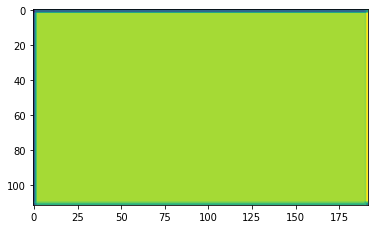

In [ ]:
plt.show(plt.imshow(preds[5, 0, :, :]))
# plt.show(plt.imshow(preds[10, :, :, 0]))

##### Test 2 predict only 1 var with the 4

**This techniques takes the four varaibles as separated channels, concatenate the predictions and then finnaly filter to extract only the area burnt.**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                          
                                                                                                  
 input_6 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                          
                                                                                                  
 input_7 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                    

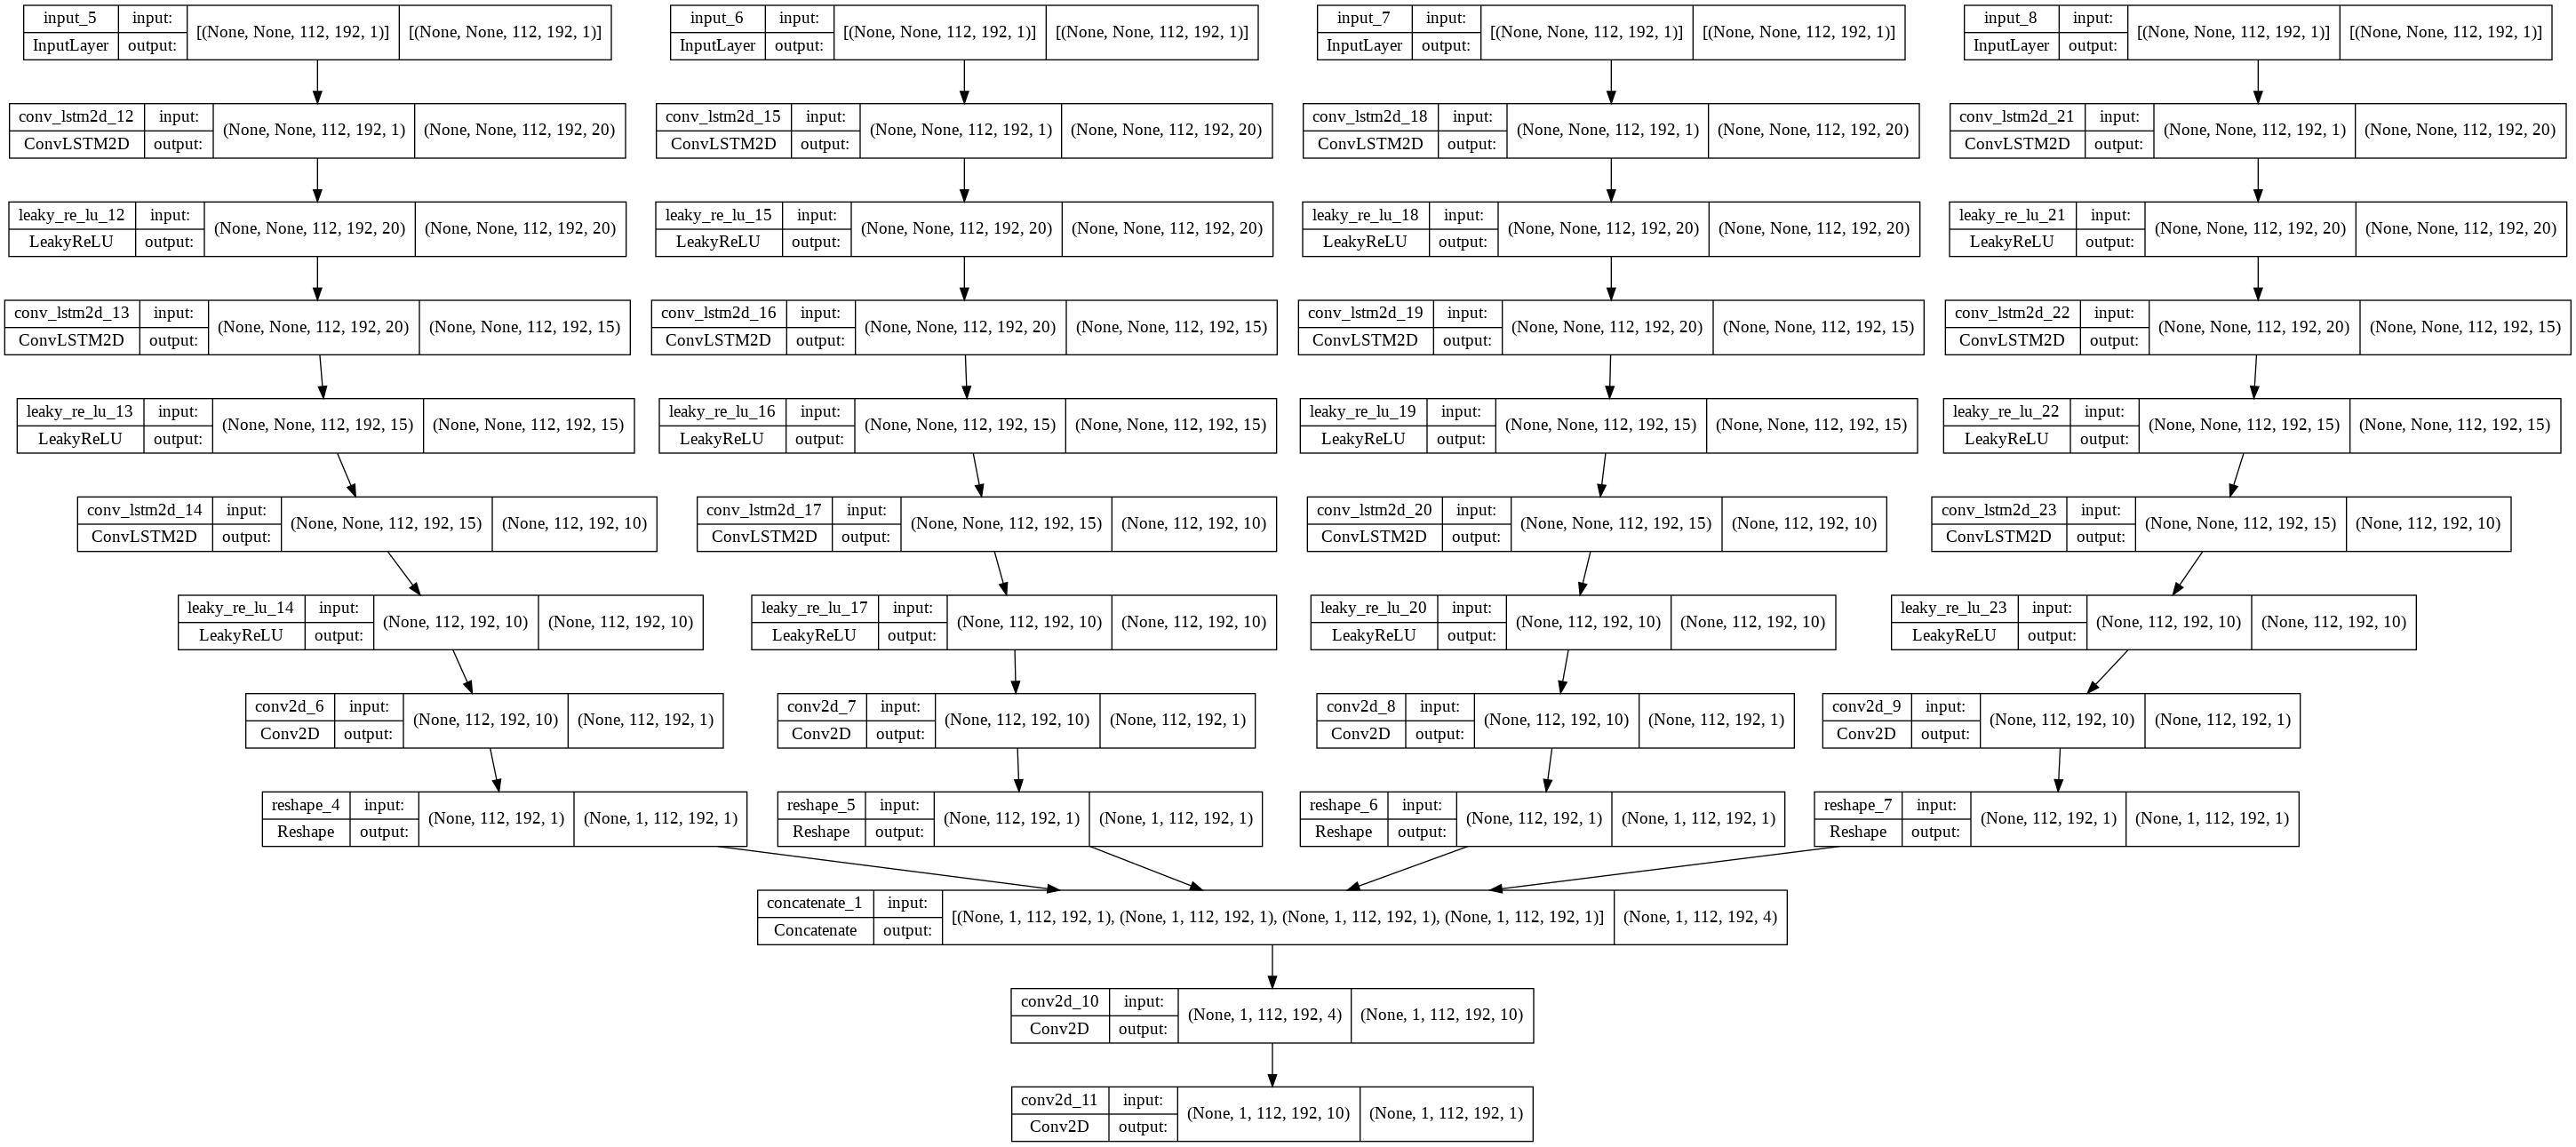

In [ ]:
with strategy.scope():
  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv3D` layer for the spatiotemporal outputs.
  inp1 = Input(shape=(None, 112, 192, 1))
  banch1 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU()(banch1)
  banch1 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch1)
  output1 = Reshape((1, 112, 192, 1))(banch1)

  inp2 = Input(shape=(None, 112, 192, 1))
  banch2 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU()(banch2)
  banch2 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch2)
  output2 = Reshape((1, 112, 192, 1))(banch2)

  inp3 = Input(shape=(None, 112, 192, 1))
  banch3 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU()(banch3)
  banch3 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch3)
  output3 = Reshape((1, 112, 192, 1))(banch3)

  inp4 = Input(shape=(None, 112, 192, 1))
  banch4 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU()(banch4)
  banch4 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch4)
  output4 = Reshape((1, 112, 192, 1))(banch4)

  #concatenate the four branch
  merging = Concatenate(axis=4)([output1, output2, output3, output4])

  # Final layer to combine the features
  FL = Conv2D(filters=10, kernel_size=(5, 5), activation="elu", padding="same")(merging)
  final_output = Conv2D(filters=1, kernel_size=(5, 5), activation="elu", padding="same")(FL)

  # Next, we will build the complete model and compile it.
  multi_CNN12to1 = Model([inp1, inp2, inp3, inp4], final_output)
    
  multi_CNN12to1.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

multi_CNN12to1.summary()

plot_model(multi_CNN12to1, show_shapes=True)

In [ ]:
start = time.time()
history = multi_CNN12to1.fit(
    [train[l, :, :, :, :1], train[l, :, :, :, 1:2], train[l, :, :, :, 2:3], train[l, :, :, :, 3:]],
    ytrain[l, :, :, :1],
    batch_size = 3,
    epochs=30,
    validation_split=0.15,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)
end = time.time()

Epoch 1/30
17/17 [==============================] - 31s 1s/step - loss: 0.0429 - val_loss: 0.0423 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - 17s 1s/step - loss: 0.0428 - val_loss: 0.0421 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - 17s 1s/step - loss: 0.0424 - val_loss: 0.0420 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - 17s 1s/step - loss: 0.0422 - val_loss: 0.0414 - lr: 0.0010
Epoch 5/30
17/17 [==============================] - 17s 1s/step - loss: 0.0419 - val_loss: 0.0412 - lr: 0.0010
Epoch 6/30
17/17 [==============================] - 17s 1s/step - loss: 0.0418 - val_loss: 0.0411 - lr: 0.0010
Epoch 7/30
17/17 [==============================] - 17s 1s/step - loss: 0.0416 - val_loss: 0.0408 - lr: 0.0010
Epoch 8/30
17/17 [==============================] - 17s 1s/step - loss: 0.0412 - val_loss: 0.0406 - lr: 0.0010
Epoch 9/30
17/17 [==============================] - 17s 1s/step - loss: 0.0411 - val_loss: 0.0404 - lr: 0.0010
E

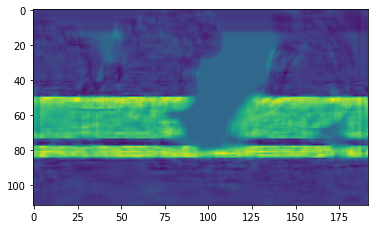

In [ ]:
plt.show(plt.imshow(preds[4,0,:,:, 0]))

##### Test 3 - Predict the 4 var with Multi head ConvLSTM

**This architecture is the same as the first test in Appendix. Except a final convolutional layers has been added after the concatenation to see if sharing informations after concatenation could help.**

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 112,   0           []                               
                                192, 1)]                                                          
                             

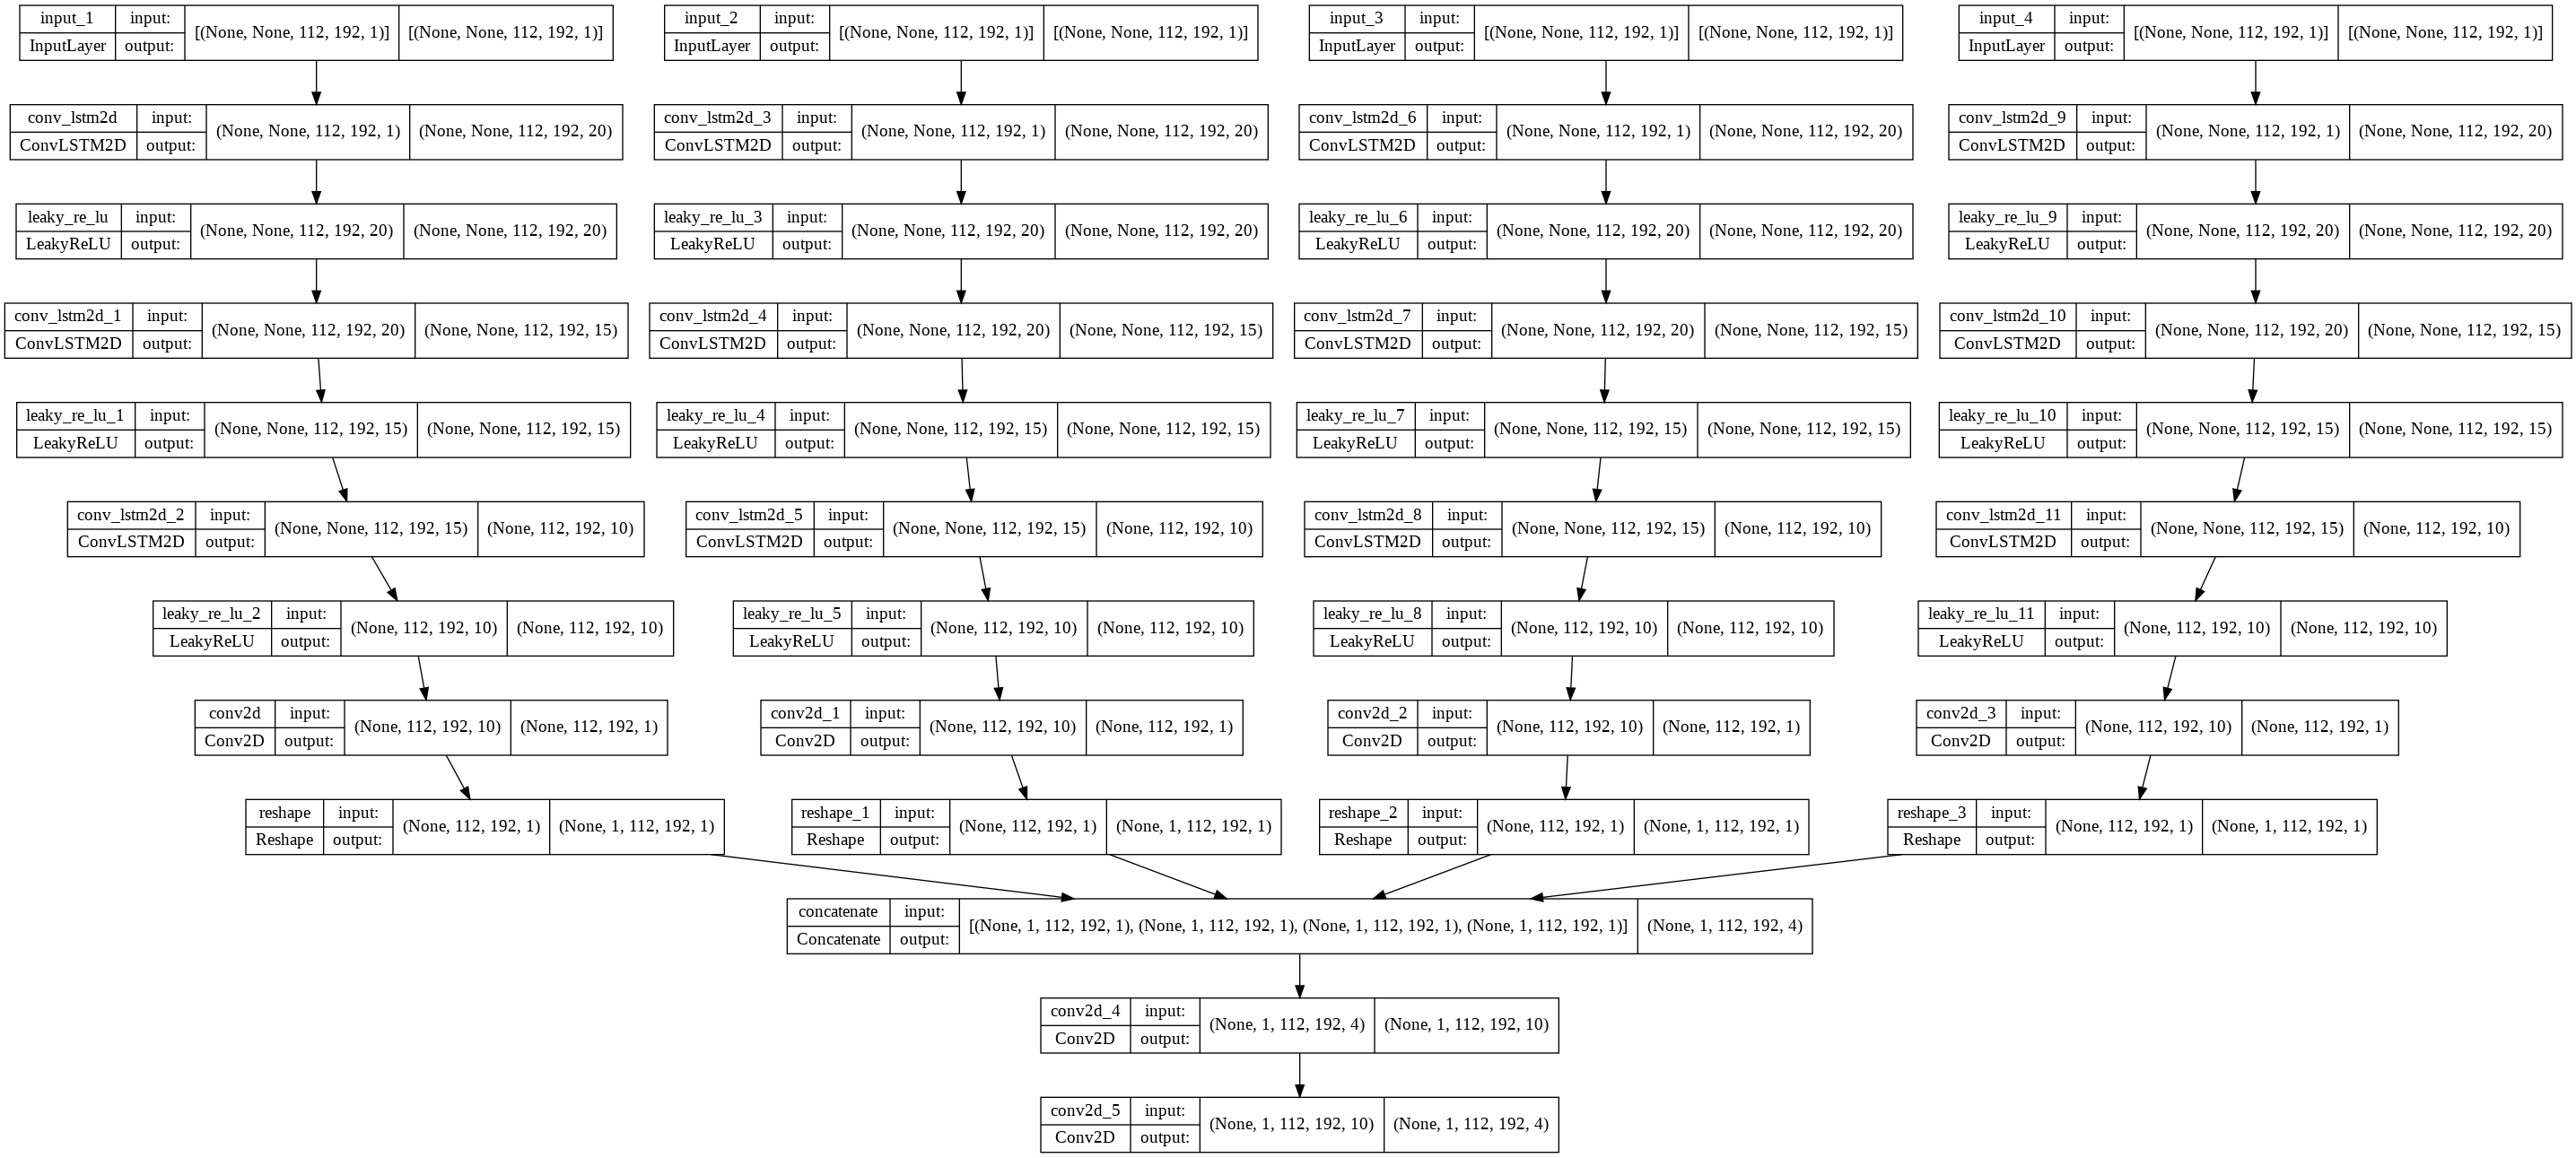

In [ ]:
with strategy.scope():
  # We will construct 3 `ConvLSTM2D` layers with batch normalization,
  # followed by a `Conv3D` layer for the spatiotemporal outputs.
  inp1 = Input(shape=(None, 112, 192, 1))
  banch1 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU(alpha=0.1)(banch1)
  banch1 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch1)
  banch1 = LeakyReLU()(banch1)
  banch1 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch1)
  output1 = Reshape((1, 112, 192, 1))(banch1)

  inp2 = Input(shape=(None, 112, 192, 1))
  banch2 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU(alpha=0.1)(banch2)
  banch2 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch2)
  banch2 = LeakyReLU()(banch2)
  banch2 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch2)
  output2 = Reshape((1, 112, 192, 1))(banch2)

  inp3 = Input(shape=(None, 112, 192, 1))
  banch3 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU(alpha=0.1)(banch3)
  banch3 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch3)
  banch3 = LeakyReLU()(banch3)
  banch3 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch3)
  output3 = Reshape((1, 112, 192, 1))(banch3)

  inp4 = Input(shape=(None, 112, 192, 1))
  banch4 = ConvLSTM2D(filters=20, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(inp4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding="same", return_sequences=True, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU(alpha=0.1)(banch4)
  banch4 = ConvLSTM2D(filters=10, kernel_size=(3, 3), padding="same", return_sequences=False, activation="elu", dropout=0.2)(banch4)
  banch4 = LeakyReLU()(banch4)
  banch4 = Conv2D(filters=1, kernel_size=(1, 1), activation="elu", padding="same")(banch4)
  output4 = Reshape((1, 112, 192, 1))(banch4)

  #concatenate the four branch
  merging = Concatenate(axis=4)([output1, output2, output3, output4])

  # Final layer to combine the features
  FL = Conv2D(filters=10, kernel_size=(5, 5), activation="elu", padding="same")(merging)
  final_output = Conv2D(filters=4, kernel_size=(5, 5), activation="elu", padding="same")(FL)

  # Next, we will build the complete model and compile it.
  multi_CNN12to1 = Model([inp1, inp2, inp3, inp4], final_output)
    
  multi_CNN12to1.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())

multi_CNN12to1.summary()

plot_model(multi_CNN12to1, show_shapes=True)

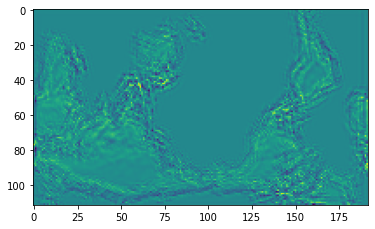

In [ ]:
plt.show(plt.imshow(preds[4,0,:,:, 0]))